In [5]:
# importing required pakages and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import zscore
from optbinning import OptimalBinning
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,RobustScaler
import category_encoders as ce
from sklearn.feature_selection import f_regression, SelectKBest,mutual_info_regression, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.svm import SVR, SVC
import xgboost
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
sb.set()

d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Regression Problem

In [2]:
ds = pd.read_csv('Auto_Insurance_Claims_amount.csv')
ds

,Customer,Country,State Code,State,Claim Amount,Response,Coverage,Education,Effective To Date,EmploymentStatus,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Claim Reason,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,US,KS,Kansas,276.351928,No,Basic,Bachelor,2/24/11,Employed,...,5,0,1,Corporate Auto,Corporate L3,Collision,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,US,NE,Nebraska,697.953590,No,Extended,Bachelor,1/31/11,Unemployed,...,42,0,8,Personal Auto,Personal L3,Scratch/Dent,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,US,OK,Oklahoma,1288.743165,No,Premium,Bachelor,2/19/11,Employed,...,38,0,2,Personal Auto,Personal L3,Collision,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,US,MO,Missouri,764.586183,No,Basic,Bachelor,1/20/11,Unemployed,...,65,0,7,Corporate Auto,Corporate L2,Collision,Call Center,529.881344,SUV,Medsize
4,HB64268,US,KS,Kansas,281.369258,No,Basic,Bachelor,2/3/11,Employed,...,44,0,1,Personal Auto,Personal L1,Collision,Agent,138.130879,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,US,MO,Missouri,2340.598798,No,Basic,Bachelor,2/10/11,Employed,...,89,0,2,Personal Auto,Personal L1,Hail,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,US,MO,Missouri,309.651122,Yes,Extended,College,2/12/11,Employed,...,28,0,1,Corporate Auto,Corporate L3,Collision,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,US,MO,Missouri,816.389043,No,Extended,Bachelor,2/6/11,Unemployed,...,37,3,2,Corporate Auto,Corporate L2,Collision,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,US,MO,Missouri,752.444244,No,Extended,College,2/3/11,Employed,...,3,0,3,Personal Auto,Personal L2,Scratch/Dent,Branch,691.200000,Four-Door Car,Large


### EDA and Data-preprocessing

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   Country                        9134 non-null   object 
 2   State Code                     9134 non-null   object 
 3   State                          9134 non-null   object 
 4   Claim Amount                   9134 non-null   float64
 5   Response                       9134 non-null   object 
 6   Coverage                       9134 non-null   object 
 7   Education                      9134 non-null   object 
 8   Effective To Date              9134 non-null   object 
 9   EmploymentStatus               9134 non-null   object 
 10  Gender                         9134 non-null   object 
 11  Income                         9134 non-null   int64  
 12  Location Code                  9134 non-null   o

By looking at above data, we don't see the any sign of missing data for any column.

In [10]:
# defining function to change a column date information into year, month and weekday.
def to_date_time(col, df):
    df[col] = pd.to_datetime(df[col], infer_datetime_format = True)
        
    if len(df[col].dt.year.unique()) != 1:
        df[col+'(year)'] = df[col].dt.year
    else:
        pass
    if len(df[col].dt.month.unique()) != 1:
        df[col+'(month)'] = df[col].dt.month
        
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
            6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df[col+'(month)'] = df[col+'(month)'].map(month_map)
    
    else:
        pass
    if len(df[col].dt.dayofweek.unique()) != 1:
        df[col+'(weekday)'] = df[col].dt.dayofweek
        
        weekday_map = {6:'SUN', 5:'SAT', 4:'FRI', 3:'THU', 2:'WED', 1:'TUE', 0: 'MON'}
        df[col+'(weekday)'] = df[col+'(weekday)'].map(weekday_map)
        
        
    df.drop([col], 1, inplace = True)
    
    return df       

In [7]:
to_date_time('Effective To Date',ds)

,Customer,Country,State Code,State,Claim Amount,Response,Coverage,Education,EmploymentStatus,Gender,...,Number of Policies,Policy Type,Policy,Claim Reason,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Effective To Date(month),Effective To Date(weekday)
0,BU79786,US,KS,Kansas,276.351928,No,Basic,Bachelor,Employed,F,...,1,Corporate Auto,Corporate L3,Collision,Agent,384.811147,Two-Door Car,Medsize,Feb,THU
1,QZ44356,US,NE,Nebraska,697.953590,No,Extended,Bachelor,Unemployed,F,...,8,Personal Auto,Personal L3,Scratch/Dent,Agent,1131.464935,Four-Door Car,Medsize,Jan,MON
2,AI49188,US,OK,Oklahoma,1288.743165,No,Premium,Bachelor,Employed,F,...,2,Personal Auto,Personal L3,Collision,Agent,566.472247,Two-Door Car,Medsize,Feb,SAT
3,WW63253,US,MO,Missouri,764.586183,No,Basic,Bachelor,Unemployed,M,...,7,Corporate Auto,Corporate L2,Collision,Call Center,529.881344,SUV,Medsize,Jan,THU
4,HB64268,US,KS,Kansas,281.369258,No,Basic,Bachelor,Employed,M,...,1,Personal Auto,Personal L1,Collision,Agent,138.130879,Four-Door Car,Medsize,Feb,THU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,US,MO,Missouri,2340.598798,No,Basic,Bachelor,Employed,M,...,2,Personal Auto,Personal L1,Hail,Web,198.234764,Four-Door Car,Medsize,Feb,THU
9130,PK87824,US,MO,Missouri,309.651122,Yes,Extended,College,Employed,F,...,1,Corporate Auto,Corporate L3,Collision,Branch,379.200000,Four-Door Car,Medsize,Feb,SAT
9131,TD14365,US,MO,Missouri,816.389043,No,Extended,Bachelor,Unemployed,M,...,2,Corporate Auto,Corporate L2,Collision,Branch,790.784983,Four-Door Car,Medsize,Feb,SUN
9132,UP19263,US,MO,Missouri,752.444244,No,Extended,College,Employed,M,...,3,Personal Auto,Personal L2,Scratch/Dent,Branch,691.200000,Four-Door Car,Large,Feb,THU


In [8]:
# here we are separating the categoric and numeric columns for separate analysis.
numeric_col = []
cat_col = []

for col in ds.columns:
    if col in ds.describe().columns:
        
        numeric_col.append(col)
    else:
        cat_col.append(col)
        
print('numeric columns: \n',numeric_col,'\n')
print('categorical columns: \n',cat_col)

numeric columns: 
 ['Claim Amount', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount'] 

categorical columns: 
 ['Customer', 'Country', 'State Code', 'State', 'Response', 'Coverage', 'Education', 'EmploymentStatus', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Policy', 'Claim Reason', 'Sales Channel', 'Vehicle Class', 'Vehicle Size', 'Effective To Date(month)', 'Effective To Date(weekday)']


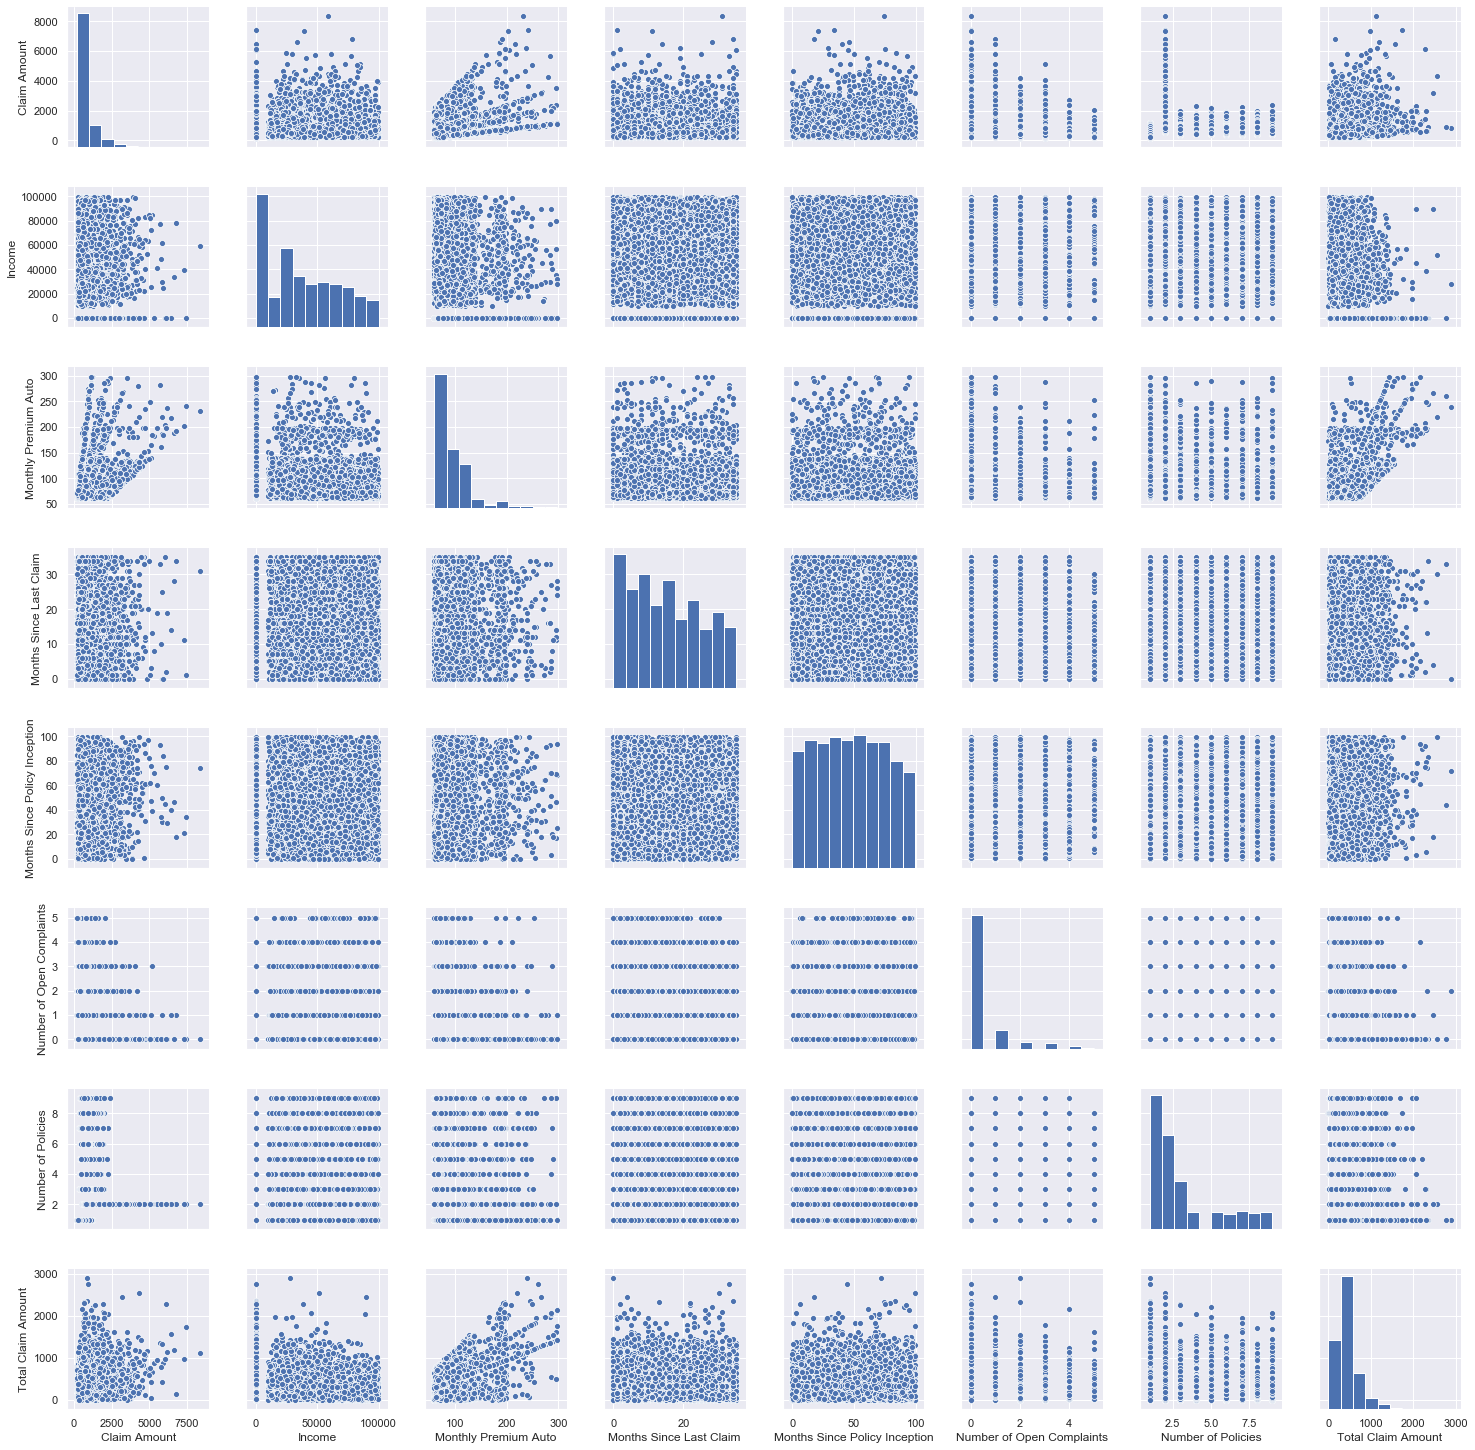

In [9]:
sb.pairplot(ds[numeric_col])

From above pairplot, we see most variables are not directly correlated with 'Claim Amount',and, most variables have right skewed distributions. We also see discrete pattern in some variables, implying  ordinal nature of those variables. 

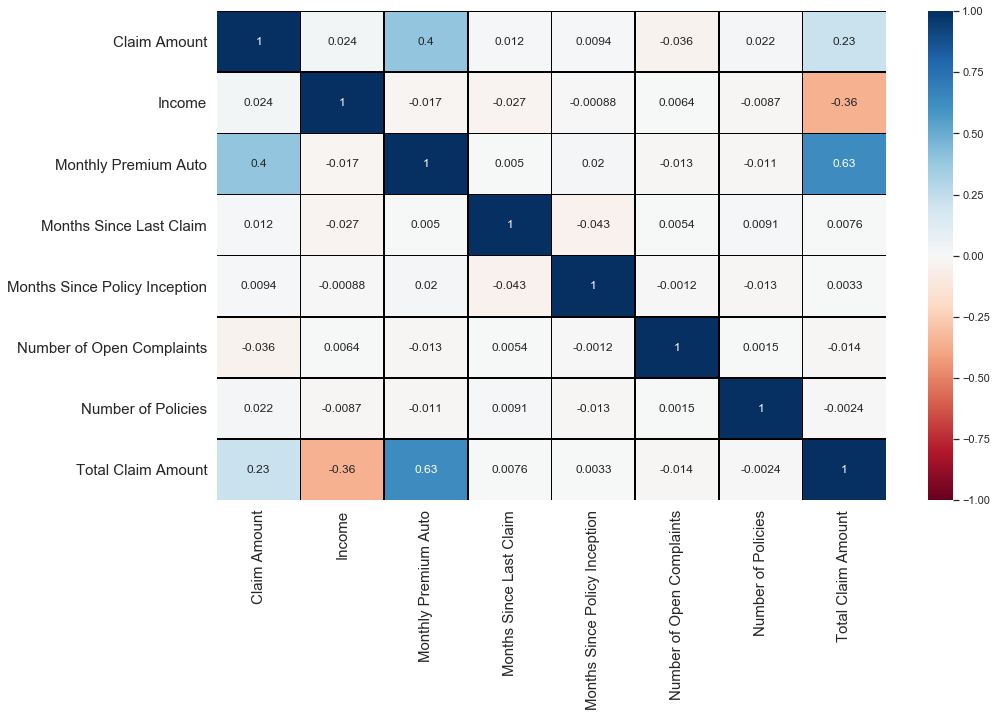

In [10]:
plt.figure(figsize = (15,9))
sb.heatmap(ds[numeric_col].corr(), cmap = 'RdBu', vmin = -1, vmax = 1, center = 0, 
           linewidth = .5, linecolor = 'black', annot = True)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

From above heatmap, we see that Monthly Premium Auto is moderately correlated with Claim Amount (target variable).

We dont see much of a correlation between variables and highest correlation is only 0.63 between Monthly Premium Auto and Total Claim Amount.

In [11]:
for col in numeric_col:
    print('no. of unique values of column ' + col + ': ', len(ds[col].unique()))

no. of unique values of column Claim Amount:  8041
no. of unique values of column Income:  5694
no. of unique values of column Monthly Premium Auto:  202
no. of unique values of column Months Since Last Claim:  36
no. of unique values of column Months Since Policy Inception:  100
no. of unique values of column Number of Open Complaints:  6
no. of unique values of column Number of Policies:  9
no. of unique values of column Total Claim Amount:  5106


From above data we see that 'Number of Open Complaints' and 'Number of Policies' has the unique value of only 6 and 9 respectively. Therefore, we shall treat them as ordinal categorical variables.

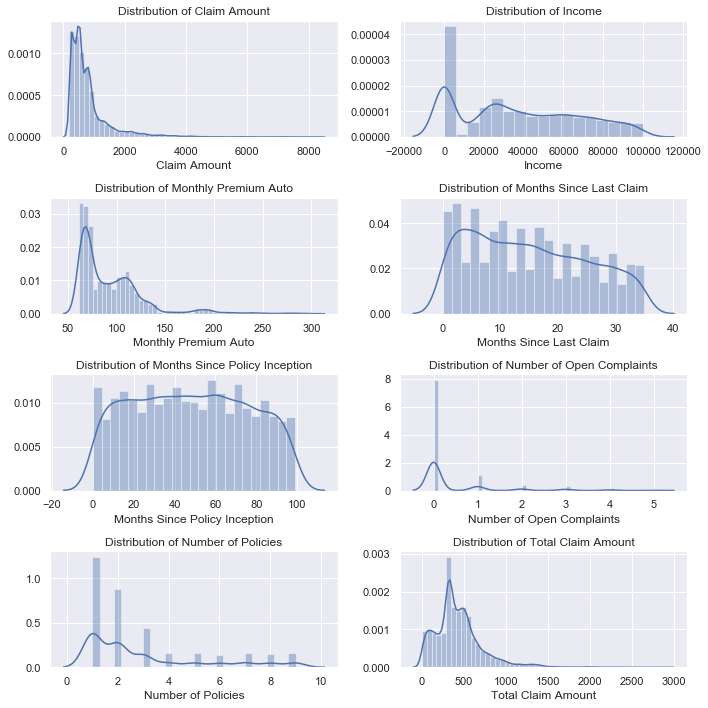

In [12]:
for i,col in enumerate(ds[numeric_col]):
    plt.subplot(4,2 ,i+1)
    sb.distplot(ds[col])
    plt.title('Distribution of '+col)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
plt.show()

As seen from pairplots, all above distributions are right skewed with exception of column 'Months Since Policy Inception'.

In [13]:
for col in cat_col:
    print('no. of unique values of column ' + col + ': ', len(ds[col].unique()))

no. of unique values of column Customer:  9134
no. of unique values of column Country:  1
no. of unique values of column State Code:  5
no. of unique values of column State:  5
no. of unique values of column Response:  2
no. of unique values of column Coverage:  3
no. of unique values of column Education:  5
no. of unique values of column EmploymentStatus:  5
no. of unique values of column Gender:  2
no. of unique values of column Location Code:  3
no. of unique values of column Marital Status:  3
no. of unique values of column Policy Type:  3
no. of unique values of column Policy:  9
no. of unique values of column Claim Reason:  4
no. of unique values of column Sales Channel:  4
no. of unique values of column Vehicle Class:  6
no. of unique values of column Vehicle Size:  3
no. of unique values of column Effective To Date(month):  2
no. of unique values of column Effective To Date(weekday):  7


Here, we see that 'Customer' columns has unique values equal to no. of rows, and since it is unique for each customer, it is not helpful for analysis and modelling so we shall drop it.
Also, we shall drop 'Country' column, since it has only  1 unique value.

In [14]:
ds.drop(['Customer','Country'], 1, inplace = True)
cat_col.remove('Customer')
cat_col.remove('Country')

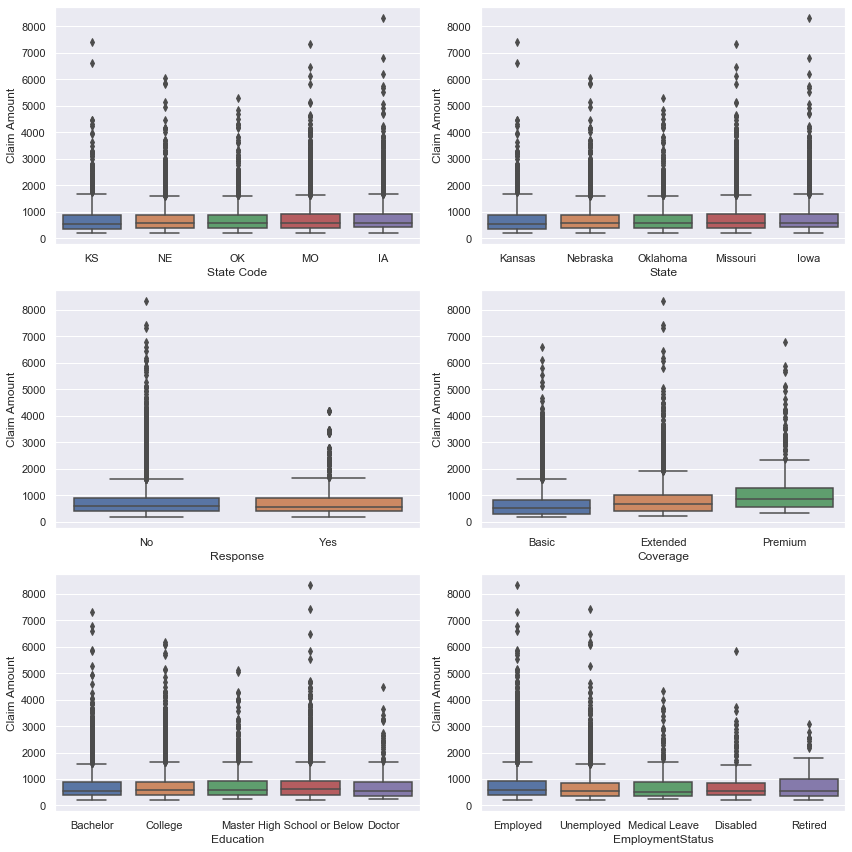

In [17]:
for i, col in enumerate(cat_col[0:6]):
    plt.subplot(3,2, i+1)

    sb.boxplot(x = col, y = 'Claim Amount', data = ds)


    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(12,12)
    plt.tight_layout()
plt.show()

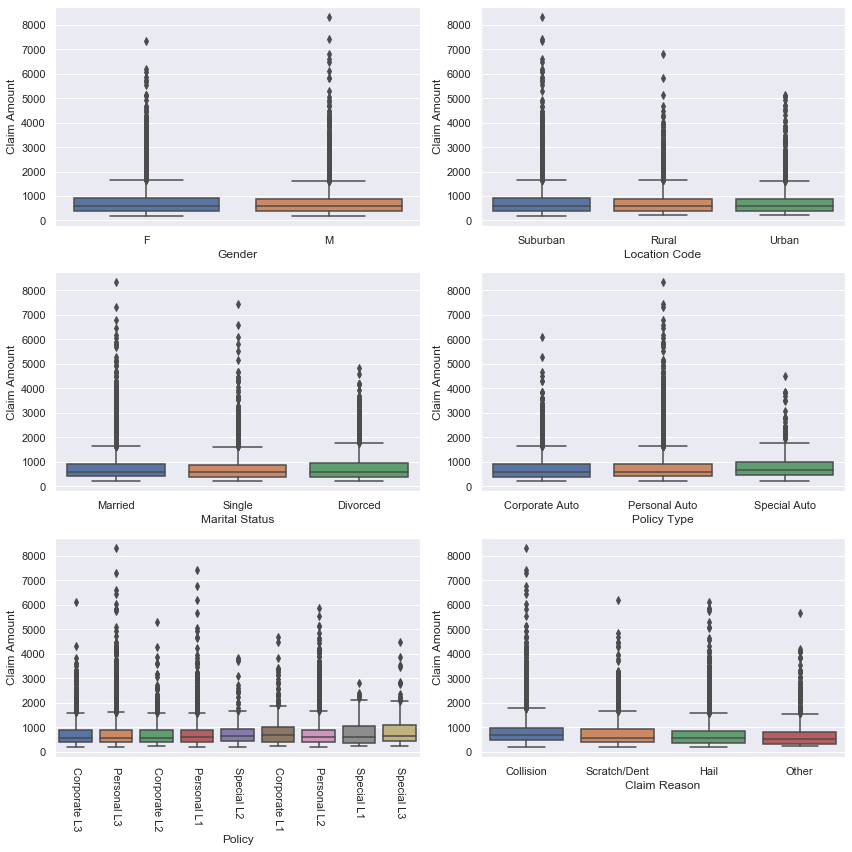

In [18]:
for i, col in enumerate(cat_col[6:12]):
   
    plt.subplot(3,2, i+1)

    sb.boxplot(x = col, y = 'Claim Amount', data = ds)

    fig, ax = plt.gcf(), plt.gca()
    if col == 'Policy':
        plt.xticks(rotation = -90)
    else:
        pass
    fig.set_size_inches(12,12)
    plt.tight_layout()
plt.show()

From above boxplots, variations of claim amount exists within categories, particularly for extreme claim amounts.

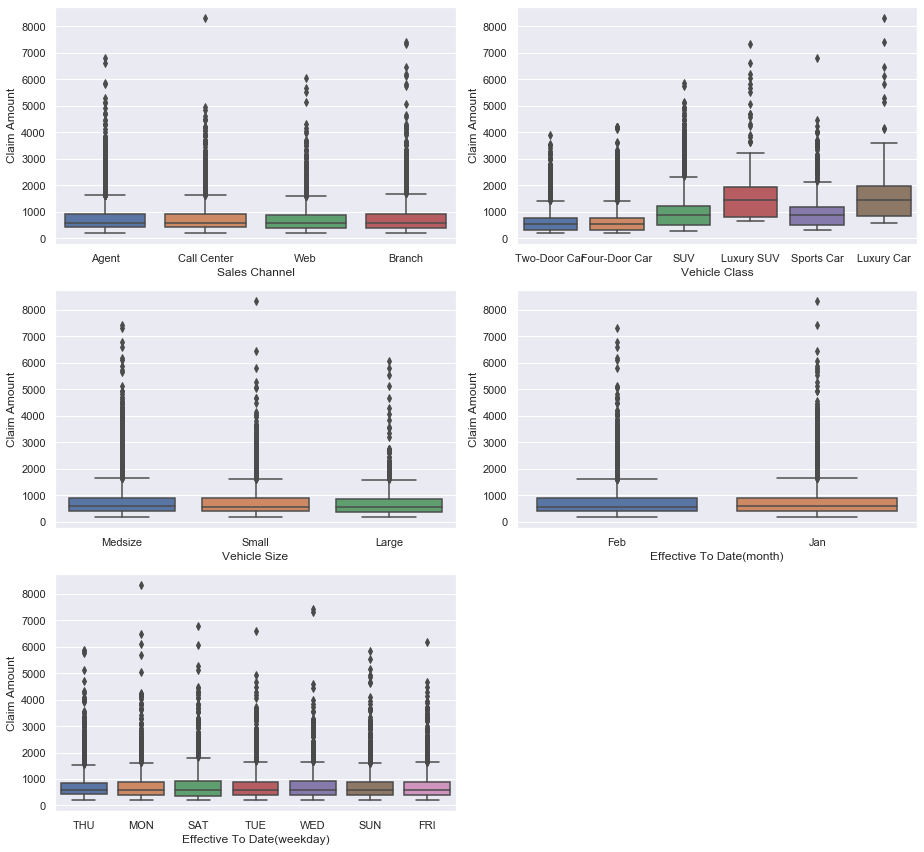

In [19]:
for i, col in enumerate(cat_col[12:]):
    plt.subplot(3,2, i+1)

    sb.boxplot(x = col, y = 'Claim Amount', data = ds)


    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(13,12)
    plt.tight_layout()
plt.show()

From above boxplots, we see variations in claim amount within different categories , particularly expensive cars like luxury cars and luxury SUVs have higher Claim Amount.

In [21]:
# extracting nominal categories from cat_col list.
ordinal_cat = ['Education', 'Coverage','Effective To Date(weekday)','Vehicle Size',
               'Number of Policies','Number of Open Complaints']
nominal_cat = []
for col in cat_col:
    if col not in ordinal_cat:
        nominal_cat.append(col)
print('nomimal_cat:',nominal_cat)

nomimal_cat: ['State Code', 'State', 'Response', 'EmploymentStatus', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Policy', 'Claim Reason', 'Sales Channel', 'Vehicle Class', 'Effective To Date(month)']


In [22]:
# removing features  from numeric_col list. 
numeric_col.remove('Number of Policies')
numeric_col.remove('Number of Open Complaints')
numeric_col.remove('Claim Amount')

In [23]:
ds[numeric_col].skew()

Income                           0.286887
Monthly Premium Auto             2.123546
Months Since Last Claim          0.278586
Months Since Policy Inception    0.040165
Total Claim Amount               1.714966
dtype: float64

In [24]:
# square-root transforming numeric features that are highly skewed.
for col in numeric_col:
    if abs(ds[col].skew()) > 0.55:
        ds[col] = (ds[col])**(1/2)

In [26]:
ds

,State Code,State,Claim Amount,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,...,Number of Policies,Policy Type,Policy,Claim Reason,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Effective To Date(month),Effective To Date(weekday)
0,KS,Kansas,276.351928,No,Basic,Bachelor,Employed,F,56274,Suburban,...,1,Corporate Auto,Corporate L3,Collision,Agent,19.616604,Two-Door Car,Medsize,Feb,THU
1,NE,Nebraska,697.953590,No,Extended,Bachelor,Unemployed,F,0,Suburban,...,8,Personal Auto,Personal L3,Scratch/Dent,Agent,33.637255,Four-Door Car,Medsize,Jan,MON
2,OK,Oklahoma,1288.743165,No,Premium,Bachelor,Employed,F,48767,Suburban,...,2,Personal Auto,Personal L3,Collision,Agent,23.800677,Two-Door Car,Medsize,Feb,SAT
3,MO,Missouri,764.586183,No,Basic,Bachelor,Unemployed,M,0,Suburban,...,7,Corporate Auto,Corporate L2,Collision,Call Center,23.019152,SUV,Medsize,Jan,THU
4,KS,Kansas,281.369258,No,Basic,Bachelor,Employed,M,43836,Rural,...,1,Personal Auto,Personal L1,Collision,Agent,11.752909,Four-Door Car,Medsize,Feb,THU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,MO,Missouri,2340.598798,No,Basic,Bachelor,Employed,M,71941,Urban,...,2,Personal Auto,Personal L1,Hail,Web,14.079587,Four-Door Car,Medsize,Feb,THU
9130,MO,Missouri,309.651122,Yes,Extended,College,Employed,F,21604,Suburban,...,1,Corporate Auto,Corporate L3,Collision,Branch,19.473058,Four-Door Car,Medsize,Feb,SAT
9131,MO,Missouri,816.389043,No,Extended,Bachelor,Unemployed,M,0,Suburban,...,2,Corporate Auto,Corporate L2,Collision,Branch,28.120899,Four-Door Car,Medsize,Feb,SUN
9132,MO,Missouri,752.444244,No,Extended,College,Employed,M,21941,Suburban,...,3,Personal Auto,Personal L2,Scratch/Dent,Branch,26.290683,Four-Door Car,Large,Feb,THU


In [27]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(ds.drop(['Claim Amount'], 1), 
                                                    ds['Claim Amount'],
                                                test_size = 0.30, random_state = 42) 


In [28]:
# dummy encoding features in nominal_cat list.
x_train = pd.get_dummies(data = x_train, prefix = nominal_cat, columns = nominal_cat, drop_first = True)
x_test = pd.get_dummies(data = x_test, prefix = nominal_cat, columns = nominal_cat, drop_first = True )

In [30]:
# label encoding features in ordinal_cat list.
for col in ordinal_cat:
    encoder = LabelEncoder()
    x_train[col]  = encoder.fit_transform(x_train[col].values.reshape(-1,1))
    x_test[col]  = encoder.transform(x_test[col].values.reshape(-1,1))

In [31]:
# Min-max scaling features in ordinal_cat list.
for col in ordinal_cat:
    
        encoder =  MinMaxScaler()
        x_train[col] = encoder.fit_transform(x_train[col].values.reshape(-1,1))
        x_test[col] = encoder.fit_transform(x_test[col].values.reshape(-1,1))

In [32]:
# robust-scaling features in numeric_col list.
for col in numeric_col:
        
        scaler = RobustScaler()
        x_train[col] = scaler.fit_transform(x_train[col].values.reshape(-1,1))
        x_test[col] = scaler.transform(x_test[col].values.reshape(-1,1))

In [33]:
x_train

,Coverage,Education,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Vehicle Size,...,Claim Reason_Scratch/Dent,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Effective To Date(month)_Jan
434,0.5,0.00,0.280829,1.044312,-0.117647,-0.702128,0.0,0.000,0.795352,0.5,...,0,0,0,0,0,0,1,0,0,0
4641,0.5,0.00,-0.136375,1.064261,-0.529412,-0.978723,0.0,0.000,0.809327,1.0,...,0,0,0,0,0,0,1,0,0,1
4952,0.5,0.25,-0.405182,1.221183,-0.647059,0.063830,0.0,0.000,0.919255,0.5,...,0,0,0,0,0,0,0,1,0,0
1489,0.5,0.25,-0.653350,0.861205,-0.529412,0.978723,0.0,0.875,1.456397,0.5,...,0,1,0,0,0,0,0,1,0,1
812,0.5,0.50,0.697840,0.000000,-0.058824,-0.617021,0.2,0.000,-1.109629,0.5,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,0.25,1.038489,-0.592583,1.000000,0.319149,0.0,0.125,-0.286093,1.0,...,1,0,0,0,0,0,0,0,0,1
5191,0.0,0.25,-0.220181,-0.258161,0.176471,0.340426,0.0,0.250,-0.117063,0.5,...,0,1,0,0,0,0,0,0,0,0
5390,0.5,0.75,-0.653350,1.024287,-0.058824,-0.936170,0.0,0.750,1.898683,0.5,...,0,0,1,0,0,0,1,0,0,1
860,0.5,0.00,-0.653350,1.221183,-0.529412,0.170213,0.0,0.125,0.919255,0.5,...,0,0,1,0,0,0,1,0,0,0


In [34]:
# using selectkbest for feature selection
selector = SelectKBest(mutual_info_regression)
selector.fit(x_train, y_train)

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x0000019B0D284288>)

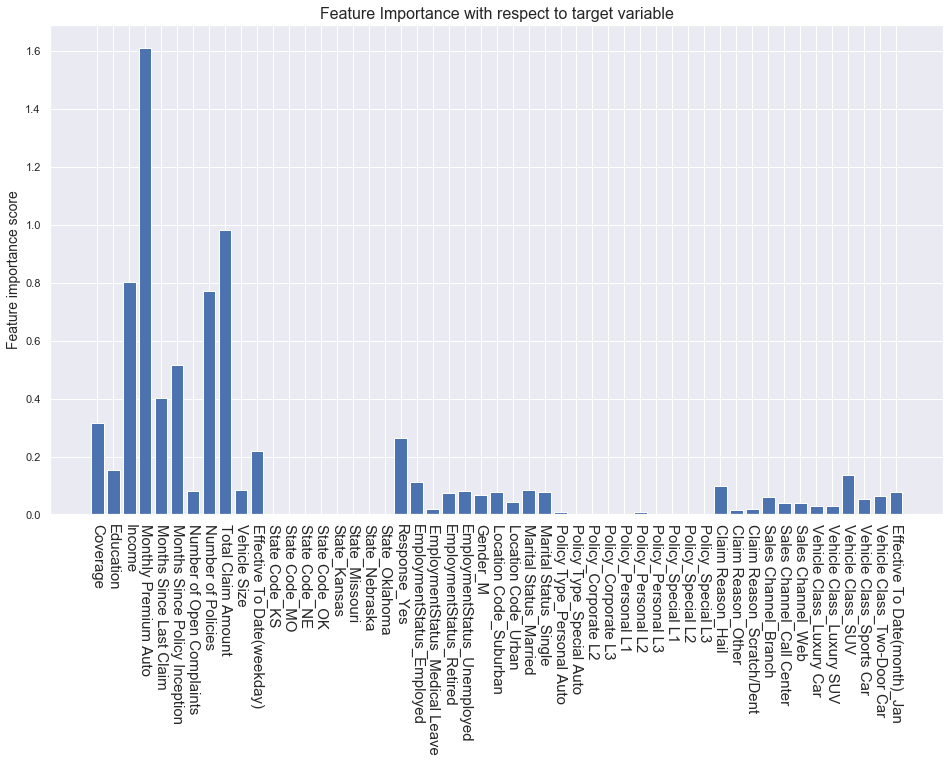

In [35]:
# plotting  the scores
plt.figure(figsize = (16,9))
plt.bar(x_train.columns, selector.scores_)
plt.xticks(rotation = -90, fontsize = 15)
plt.title('Feature Importance with respect to target variable', fontsize = 16)
plt.ylabel('Feature importance score', fontsize = 14)
plt.show()

From above plot we see Monthly Premium Auto has the highest score, also we see many features that has almost zero score and not so important in determining the target variable (i.e. Claim Amount), and would therefore act as unnecessary noise to our model.
So, we shall filter out to only those variables that contribute in determining our target variable.

In [36]:
selector = pd.DataFrame(dict(Feature = list(x_train.columns), Scores = selector.scores_))
selector.sort_values(by = 'Scores', ascending = False ).head(30)

,Feature,Scores
3,Monthly Premium Auto,1.609968
8,Total Claim Amount,0.981137
2,Income,0.801947
7,Number of Policies,0.772934
5,Months Since Policy Inception,0.516475
4,Months Since Last Claim,0.402053
0,Coverage,0.314179
19,Response_Yes,0.265266
10,Effective To Date(weekday),0.217782
1,Education,0.152664


In [37]:
# keeping features with scores above threshold score.
threshold = 0
selected_features = selector[selector.Scores > threshold]
selected_features.sort_values(by = 'Scores', ascending = False )

,Feature,Scores
3,Monthly Premium Auto,1.609968
8,Total Claim Amount,0.981137
2,Income,0.801947
7,Number of Policies,0.772934
5,Months Since Policy Inception,0.516475
4,Months Since Last Claim,0.402053
0,Coverage,0.314179
19,Response_Yes,0.265266
10,Effective To Date(weekday),0.217782
1,Education,0.152664


In [38]:
print('no. of selected features:', len(selected_features))

no. of selected features: 41


In [39]:
# selecting highest scoring features for train and test set.
x_train_red = x_train[list(selected_features['Feature'])]
x_test_red = x_test[list(selected_features['Feature'])]

In [40]:
x_train_red.shape, x_test_red.shape

((6393, 41), (2741, 41))

In [41]:
x_train_red

,Coverage,Education,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Vehicle Size,...,Claim Reason_Scratch/Dent,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Effective To Date(month)_Jan
434,0.5,0.00,0.280829,1.044312,-0.117647,-0.702128,0.0,0.000,0.795352,0.5,...,0,0,0,0,0,0,1,0,0,0
4641,0.5,0.00,-0.136375,1.064261,-0.529412,-0.978723,0.0,0.000,0.809327,1.0,...,0,0,0,0,0,0,1,0,0,1
4952,0.5,0.25,-0.405182,1.221183,-0.647059,0.063830,0.0,0.000,0.919255,0.5,...,0,0,0,0,0,0,0,1,0,0
1489,0.5,0.25,-0.653350,0.861205,-0.529412,0.978723,0.0,0.875,1.456397,0.5,...,0,1,0,0,0,0,0,1,0,1
812,0.5,0.50,0.697840,0.000000,-0.058824,-0.617021,0.2,0.000,-1.109629,0.5,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,0.25,1.038489,-0.592583,1.000000,0.319149,0.0,0.125,-0.286093,1.0,...,1,0,0,0,0,0,0,0,0,1
5191,0.0,0.25,-0.220181,-0.258161,0.176471,0.340426,0.0,0.250,-0.117063,0.5,...,0,1,0,0,0,0,0,0,0,0
5390,0.5,0.75,-0.653350,1.024287,-0.058824,-0.936170,0.0,0.750,1.898683,0.5,...,0,0,1,0,0,0,1,0,0,1
860,0.5,0.00,-0.653350,1.221183,-0.529412,0.170213,0.0,0.125,0.919255,0.5,...,0,0,1,0,0,0,1,0,0,0


In [42]:
k = KFold(n_splits = 10)

### Base Model Evaluation

model: RandomForestRegressor()
CV score:0.7015979056173864
score_std: 0.02162221064664307
----------
model: LinearRegression(normalize=True)
CV score:0.14312344631435703
score_std: 0.0421226889049918
----------
model: SVR()
CV score:-0.029775691126156988
score_std: 0.011974717434234085
----------
model: AdaBoostRegressor()
CV score:-0.034639514091314674
score_std: 0.16597445999663837
----------
model: GradientBoostingRegressor()
CV score:0.6790905936285663
score_std: 0.017902184188092824
----------
model: KNeighborsRegressor()
CV score:0.04559408390970086
score_std: 0.07635255001290198
----------
model: XGBRegressor(silent=True)
CV score:0.6812600028952446
score_std: 0.01881916361313791
----------
model: Lasso(normalize=True)
CV score:0.1422041123641821
score_std: 0.01678400100230948
----------
model: Ridge(normalize=True)
CV score:0.1414213666556484
score_std: 0.015348633434663016
----------
model: ElasticNet()
CV score:0.1278525808928394
score_std: 0.012203982419751428
----------
mod

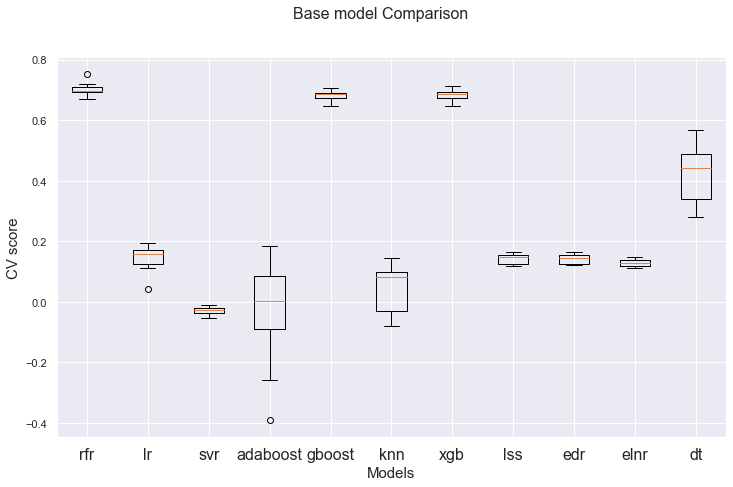

In [43]:
# inilializing different models
rfr = RandomForestRegressor()
svr = SVR()
lr = LinearRegression(normalize = True)
adaboost =  AdaBoostRegressor()
gboost = GradientBoostingRegressor()
knn = KNeighborsRegressor()
xgb = xgboost.XGBRegressor(silent = True)
lss = Lasso(normalize = True)
rdr = Ridge(normalize = True)
elnr = ElasticNet()
dt = DecisionTreeRegressor()

models = [rfr, lr, svr, adaboost, gboost, knn, xgb, lss, rdr, elnr, dt]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train_red, y_train, cv = k, scoring = 'r2', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 16)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rfr', 'lr','svr', 'adaboost', 'gboost', 'knn', 'xgb','lss','edr','elnr','dt'],
                  fontsize = 16)
plt.xlabel('Models', fontsize = 15)
plt.ylabel('CV score', fontsize = 15)
fig.set_size_inches(12,7)
plt.show() 

From above cross-val-score, we see that models like- rfr, gboost and xgb performed considerably better then the other models, so therefore we shall choose these models for further tuning.

### Hyper-parameter tuning

In [44]:
# initializing parameters for each models for model-tuning.
param_gboost =  dict(
    learning_rate = [0.01,0.03,0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.5],
    max_depth = [2,3,4, 5, 6,7,8,9,10],
    n_estimators = [100, 150, 200,250,300],
    min_samples_split = [1,2,3], random_state = [37,38,39,40,41,42,43,44,45],
    alpha = [0.05,0.1,0.5,0.75,1,1.75,2])

param_rfr = dict(n_estimators = [10,15,20,25,30,45,50], criterion = ['mse', 'mae'],
                max_depth = [2,3,4,5,6,7,None],min_samples_split = [1,2,3,4,5],
                min_samples_leaf = [1,2,3,4], random_state = [37,38,39,40,41,42,43,44,45])

  
param_xgb = dict( learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15],
     min_child_weight = [ 1, 3, 5, 7 ],
     gamma = [0.0, 0.1, 0.2 , 0.3, 0.4 ],
     colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ],
     alpha = [0.05,0.1,0.5,0.75,1,1.75,2]
     )


In [45]:
# model and parameter list.
model_param_list = [(gboost,param_gboost),(rfr,param_rfr), (xgb,param_xgb)]

In [46]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_rearch = RandomizedSearchCV(model, param, cv = k, n_jobs = -1, scoring = 'r2',
                                 random_state = 42)
    r_rearch.fit(x_train_red, y_train.values.ravel())
    best_cvscore = r_rearch.best_score_
    best_param = r_rearch.best_params_
    best_estimator = r_rearch.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
    
print('best_estimators:',best_estimator_list)

model: GradientBoostingRegressor()
best_cvscore: 0.6758616911778933
best_param: {'random_state': 40, 'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 3, 'learning_rate': 0.15, 'alpha': 0.1}


model: RandomForestRegressor()
best_cvscore: 0.6886705043008382
best_param: {'random_state': 39, 'n_estimators': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'mae'}


model: XGBRegressor(silent=True)
best_cvscore: 0.6823434876017956
best_param: {'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.5, 'alpha': 1.75}


best_estimators: [GradientBoostingRegressor(alpha=0.1, learning_rate=0.15, min_samples_split=3,
                          random_state=40), RandomForestRegressor(criterion='mae', min_samples_leaf=2, min_samples_split=3,
                      n_estimators=25, random_state=39), XGBRegressor(alpha=1.75, colsample_bytree=0.5, gamma=0.2, learning_rate=0.15,
             max_depth=4, min_child_weight

### Testing

In [47]:
# testing for train data
print('****TRAIN RESULTS****')
print('\n')

for model in best_estimator_list:
    model.fit(x_train_red, y_train)
    y_pred = model.predict(x_train_red)
    score = r2_score(y_train, y_pred)
    print('model',model)
    print('accuracy (r2_score):',  round(score*100,2),'%')
    print('root_mean_squared_error:',mean_squared_error(y_train, y_pred, squared = False))
    print('-------------------------------------------')

****TRAIN RESULTS****


model GradientBoostingRegressor(alpha=0.1, learning_rate=0.15, min_samples_split=3,
                          random_state=40)
accuracy (r2_score): 75.58 %
root_mean_squared_error: 331.9661609405674
-------------------------------------------
model RandomForestRegressor(criterion='mae', min_samples_leaf=2, min_samples_split=3,
                      n_estimators=25, random_state=39)
accuracy (r2_score): 90.76 %
root_mean_squared_error: 204.18495490562535
-------------------------------------------
model XGBRegressor(alpha=1.75, colsample_bytree=0.5, gamma=0.2, learning_rate=0.15,
             max_depth=4, min_child_weight=7, silent=True)
accuracy (r2_score): 76.73 %
root_mean_squared_error: 324.0324755248311
-------------------------------------------


In [48]:
#testing for test data
print('****TEST RESULTS****')
print('\n')

for model in best_estimator_list:
    model.fit(x_train_red, y_train)
    y_pred = model.predict(x_test_red)
    score = r2_score(y_test, y_pred)
    print('model',model)
    print('accuracy (r2_score):',  round(score*100,2),'%')
    print('root_mean_squared_error:',mean_squared_error(y_test, y_pred, squared = False))
    print('-------------------------------------------')

****TEST RESULTS****


model GradientBoostingRegressor(alpha=0.1, learning_rate=0.15, min_samples_split=3,
                          random_state=40)
accuracy (r2_score): 66.86 %
root_mean_squared_error: 415.308754123692
-------------------------------------------
model RandomForestRegressor(criterion='mae', min_samples_leaf=2, min_samples_split=3,
                      n_estimators=25, random_state=39)
accuracy (r2_score): 70.28 %
root_mean_squared_error: 393.252209889643
-------------------------------------------
model XGBRegressor(alpha=1.75, colsample_bytree=0.5, gamma=0.2, learning_rate=0.15,
             max_depth=4, min_child_weight=7, silent=True)
accuracy (r2_score): 67.93 %
root_mean_squared_error: 408.548303774649
-------------------------------------------


From above train and test results, we see that RandomForestRegressor has lowest root mean sqaured error and highest r2 score, compared to other models, hence, we shall choose it as our regression model for this project.

In [49]:
# selecting the best model as RandomForestRegressor 
selected_model =  RandomForestRegressor(criterion='mae', min_samples_leaf=2, min_samples_split=3,
                      n_estimators=25, random_state=39)

selected_model.fit(x_train_red, y_train)

y_pred = selected_model.predict(x_test_red)

In [111]:
test_df = pd.DataFrame({'Actual Claim Amount ':y_test.values,'Predicted Claim Amount':y_pred})

In [112]:
test_df.to_csv('claim_amount_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


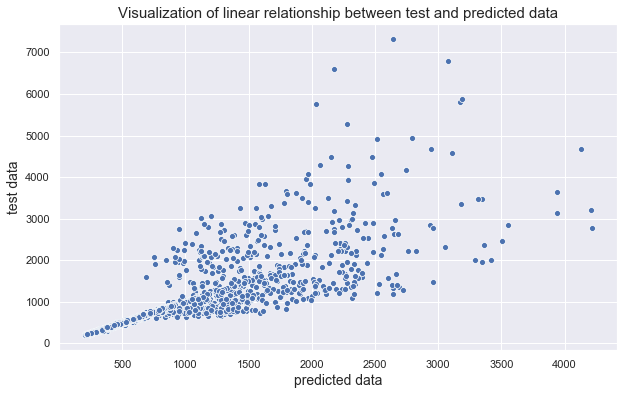

In [50]:
plt.figure(figsize = (10,6))
sb.scatterplot(y_pred,y_test )
plt.xlabel('predicted data', fontsize = 14)
plt.ylabel('test data',  fontsize = 14)
plt.title('Visualization of linear relationship between test and predicted data',fontsize = 15 )
plt.show()


From above plot, although the scatter plot gets larger spread at higher values, we can still visualize the linear relationship.

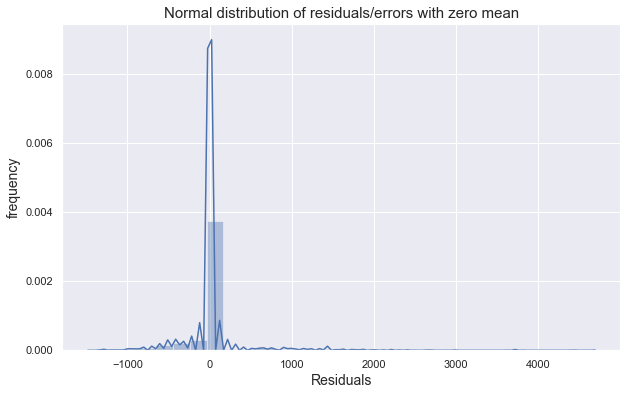

In [51]:
plt.figure(figsize = (10,6))
sb.distplot((y_test-y_pred), bins = 30)
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('frequency',  fontsize = 14)
plt.title('Normal distribution of residuals/errors',fontsize = 15 )
plt.show()

From above distribution of residuals, we can see that the distribution is almost normally distributed, with mean approximately equal to zero.

In [113]:
# Saving the final model as RandomForestRegressor for regression problem.
import joblib

joblib.dump(selected_model, 'claim_amount_pred.obj')
print('Model successfully saved.')

Model successfully saved.


## Classification Problem

In [114]:
ds2  = pd.read_csv('Automobile_insurance_fraud.csv')
ds2

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,16-07-1991,OH,500/1000,1000,1310.80,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,285,41,186934,05-01-2014,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,130,34,918516,17-02-2003,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,458,62,533940,18-11-2011,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


### EDA and Data-preprocessing

In [115]:
ds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

From above info table, we see no sign of missing values. Also, column _C39 has no records, so we shall remove it.

In [116]:
ds2.drop('_c39',1,inplace = True)

In [117]:
# extracting year, month and weekday from date columns.
to_date_time('policy_bind_date',ds2)
to_date_time('incident_date',ds2)

,months_as_customer,age,policy_number,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,policy_bind_date(year),policy_bind_date(month),policy_bind_date(weekday),incident_date(month),incident_date(weekday)
0,328,48,521585,OH,250/500,1000,1406.91,0,466132,MALE,...,52080,Saab,92x,2004,Y,2014,Oct,FRI,Jan,SUN
1,228,42,342868,IN,250/500,2000,1197.22,5000000,468176,MALE,...,3510,Mercedes,E400,2007,Y,2006,Jun,TUE,Jan,WED
2,134,29,687698,OH,100/300,2000,1413.14,5000000,430632,FEMALE,...,23100,Dodge,RAM,2007,N,2000,Sep,WED,Feb,SUN
3,256,41,227811,IL,250/500,2000,1415.74,6000000,608117,FEMALE,...,50720,Chevrolet,Tahoe,2014,Y,1990,May,FRI,Jan,SAT
4,228,44,367455,IL,500/1000,1000,1583.91,6000000,610706,MALE,...,4550,Accura,RSX,2009,N,2014,Jun,FRI,Feb,TUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,OH,500/1000,1000,1310.80,0,431289,FEMALE,...,61040,Honda,Accord,2006,N,1991,Jul,TUE,Feb,SUN
996,285,41,186934,IL,100/300,1000,1436.79,0,608177,FEMALE,...,72320,Volkswagen,Passat,2015,N,2014,Jan,SUN,Jan,SAT
997,130,34,918516,OH,250/500,500,1383.49,3000000,442797,FEMALE,...,52500,Suburu,Impreza,1996,N,2003,Feb,MON,Jan,FRI
998,458,62,533940,IL,500/1000,2000,1356.92,5000000,441714,MALE,...,36540,Audi,A5,1998,N,2011,Nov,FRI,Feb,THU


In [118]:
# here we are separating the categoric and numeric columns for separate analysis.
numeric = []
cat = []

for col in ds2.columns:
    if col in ds2.describe().columns:
        
        numeric.append(col)
    else:
        cat.append(col)
        
print('numeric columns: \n',numeric,'\n')
print('categorical columns: \n',cat)

numeric columns: 
 ['months_as_customer', 'age', 'policy_number', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year', 'policy_bind_date(year)'] 

categorical columns: 
 ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'property_damage', 'police_report_available', 'auto_make', 'auto_model', 'fraud_reported', 'policy_bind_date(month)', 'policy_bind_date(weekday)', 'incident_date(month)', 'incident_date(weekday)']


In [119]:
for col in numeric:
    print('no. of unique values of column ' + col + ': ', len(ds2[col].unique()))

no. of unique values of column months_as_customer:  391
no. of unique values of column age:  46
no. of unique values of column policy_number:  1000
no. of unique values of column policy_deductable:  3
no. of unique values of column policy_annual_premium:  991
no. of unique values of column umbrella_limit:  11
no. of unique values of column insured_zip:  995
no. of unique values of column capital-gains:  338
no. of unique values of column capital-loss:  354
no. of unique values of column incident_hour_of_the_day:  24
no. of unique values of column number_of_vehicles_involved:  4
no. of unique values of column bodily_injuries:  3
no. of unique values of column witnesses:  4
no. of unique values of column total_claim_amount:  763
no. of unique values of column injury_claim:  638
no. of unique values of column property_claim:  626
no. of unique values of column vehicle_claim:  726
no. of unique values of column auto_year:  21
no. of unique values of column policy_bind_date(year):  26


From above data, policy_number being unqiue to each customer adds no value in analysis and modelling, so we shall drop it. We also see some columns having less number of unique values to which we will treat as ordinal categorical data.

In [120]:
ds2.drop('policy_number', 1, inplace = True)
numeric.remove('policy_number')

In [121]:
for col in cat:
    print('no. of unique values of column ' + col + ': ', len(ds2[col].unique()))

no. of unique values of column policy_state:  3
no. of unique values of column policy_csl:  3
no. of unique values of column insured_sex:  2
no. of unique values of column insured_education_level:  7
no. of unique values of column insured_occupation:  14
no. of unique values of column insured_hobbies:  20
no. of unique values of column insured_relationship:  6
no. of unique values of column incident_type:  4
no. of unique values of column collision_type:  4
no. of unique values of column incident_severity:  4
no. of unique values of column authorities_contacted:  5
no. of unique values of column incident_state:  7
no. of unique values of column incident_city:  7
no. of unique values of column incident_location:  1000
no. of unique values of column property_damage:  3
no. of unique values of column police_report_available:  3
no. of unique values of column auto_make:  14
no. of unique values of column auto_model:  39
no. of unique values of column fraud_reported:  2
no. of unique values

From above data, we see incident_location all unique values, so we shall drop it.

In [122]:
ds2.drop('incident_location', 1, inplace = True)
cat.remove('incident_location')

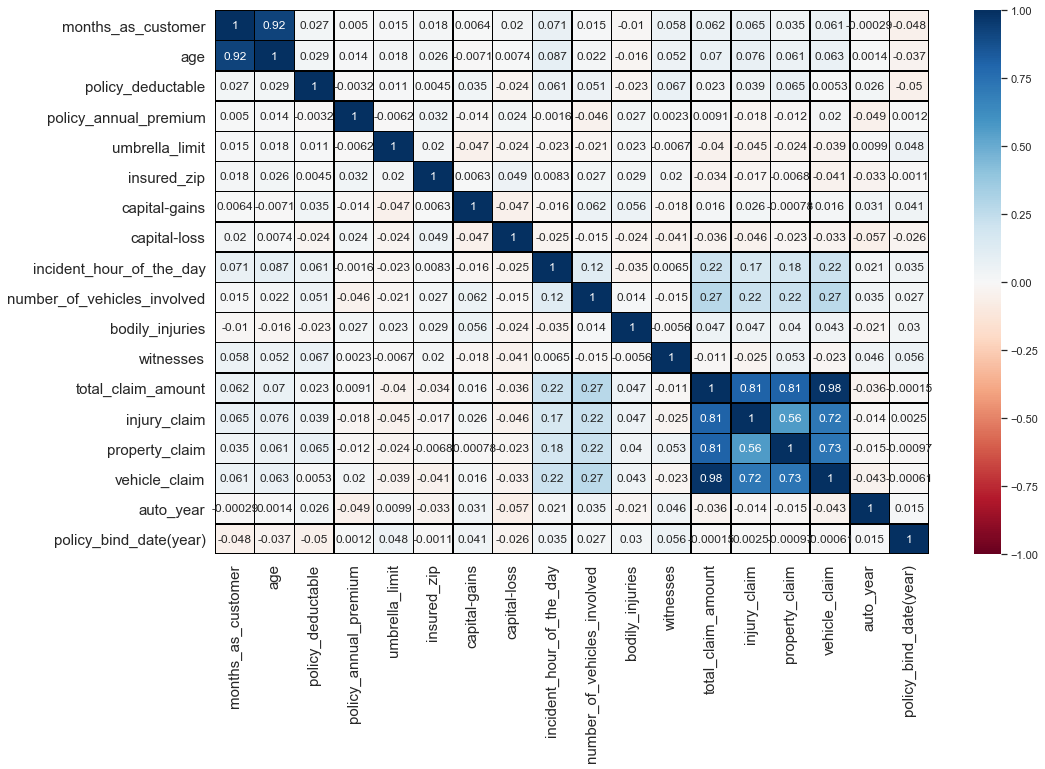

In [123]:
plt.figure(figsize = (16,10))
sb.heatmap(ds2[numeric].corr(), cmap = 'RdBu', vmin = -1, vmax = 1, center = 0, 
           linewidth = .5, linecolor = 'black', annot = True)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

From above heatmap, we see column total_claim_amount is highly correlated with other features.
Also,  months_as_customer is highly correlated with age.

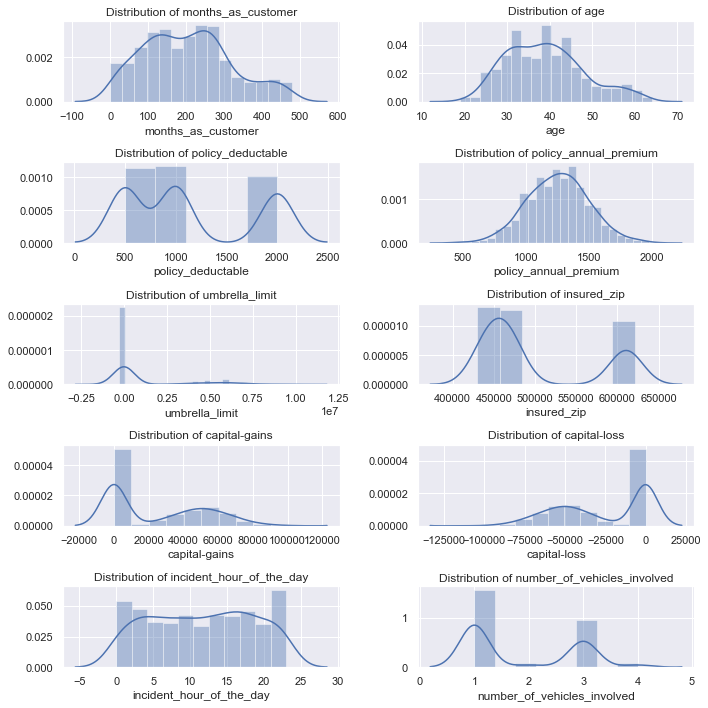

In [124]:
for i,col in enumerate(ds2[numeric].columns[0:10]):
    plt.subplot(5,2 ,i+1)
    sb.distplot(ds2[col])
    plt.title('Distribution of '+col)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
plt.show()

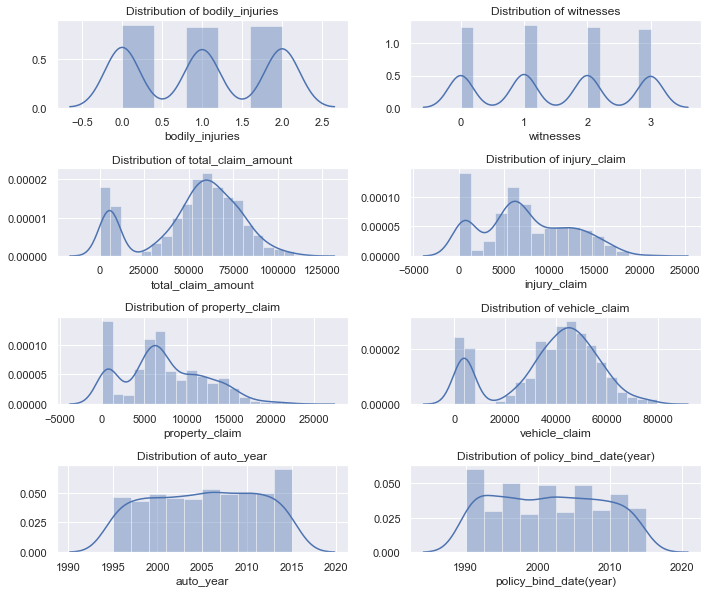

In [125]:
for i,col in enumerate(numeric[10:]):
    plt.subplot(5,2 ,i+1)
    sb.distplot(ds2[col])
    plt.title('Distribution of '+col)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
plt.show()

From above distplot, we see mix of different types of distributions. And there are columns having discrete values as well.

Also, we see columns like capital-gains and capital-loss share symmetrical distribution.

We  see almost similar distribution for property_claim and injury claim, also for total_claim_amount and vehicle_claim.

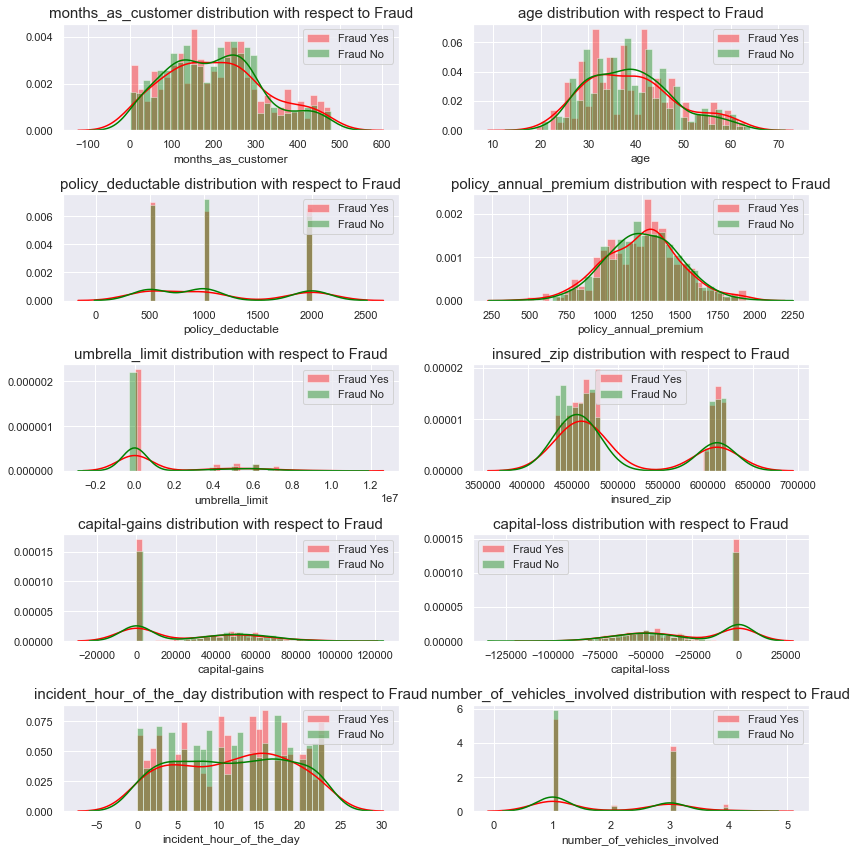

In [126]:
for i, col in enumerate(numeric[0:10]):
    
    plt.subplot(5,2, i+1)

    sb.distplot(ds2[col][ds2['fraud_reported'] == 'Y'], kde = True, bins = 30 , color = 'red')
    sb.distplot(ds2[col][ds2['fraud_reported'] == 'N'], kde = True, bins = 30, color = 'green')


    plt.legend(['Fraud Yes','Fraud No'])

    plt.title(col+' distribution with respect to Fraud', fontsize = 15)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(12,12)
    plt.tight_layout()
plt.show()

From above distribution, we can combine capital-gains and capital-loss by subraction, as they are related to each other, and by doing so we can find the net value, thus, reducing one feature. 

In [127]:
# subracting 'capital-loss' from 'capital-gains' to form new a feature.
ds2['capital(gain-loss)'] = ds2['capital-gains'] - ds2['capital-loss']
ds2.drop(['capital-gains','capital-loss'],1, inplace = True)

In [128]:
# removing and appending columns.
numeric.remove('capital-gains')
numeric.remove('capital-loss')
numeric.append('capital(gain-loss)')

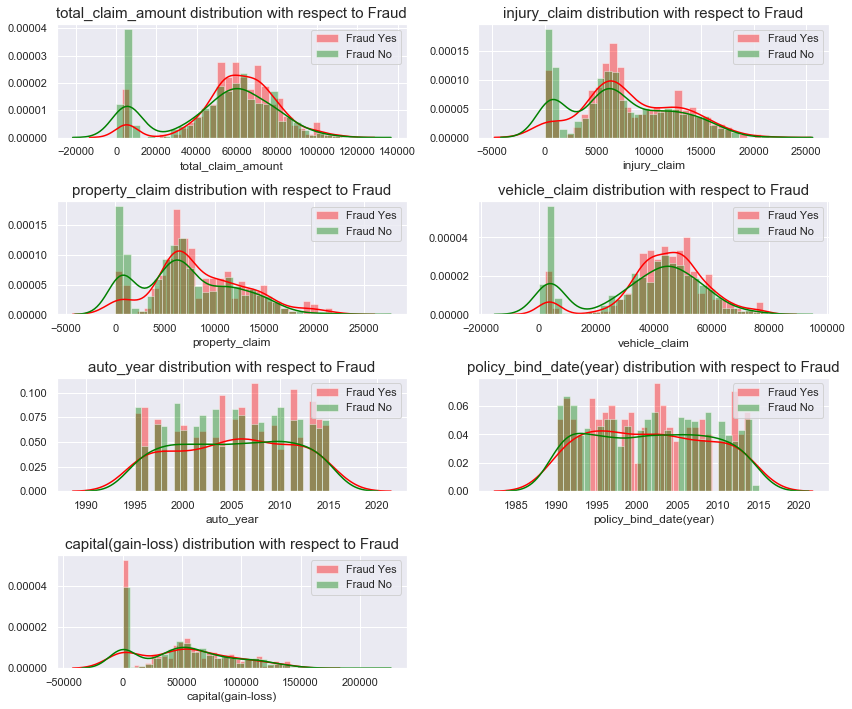

In [129]:
for i, col in enumerate(numeric[10:]):
    
    plt.subplot(5,2, i+1)

    sb.distplot(ds2[col][ds2['fraud_reported'] == 'Y'], kde = True, bins = 30 , color = 'red')
    sb.distplot(ds2[col][ds2['fraud_reported'] == 'N'], kde = True, bins = 30, color = 'green')


    plt.legend(['Fraud Yes','Fraud No'])

    plt.title(col+' distribution with respect to Fraud', fontsize = 15)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(12,12)
    plt.tight_layout()
plt.show()

From above distplots, we see that for features like- property_claim, vehicle_claim, injury_claim and total_claim_amount, fruad is likey to occur at higher values.

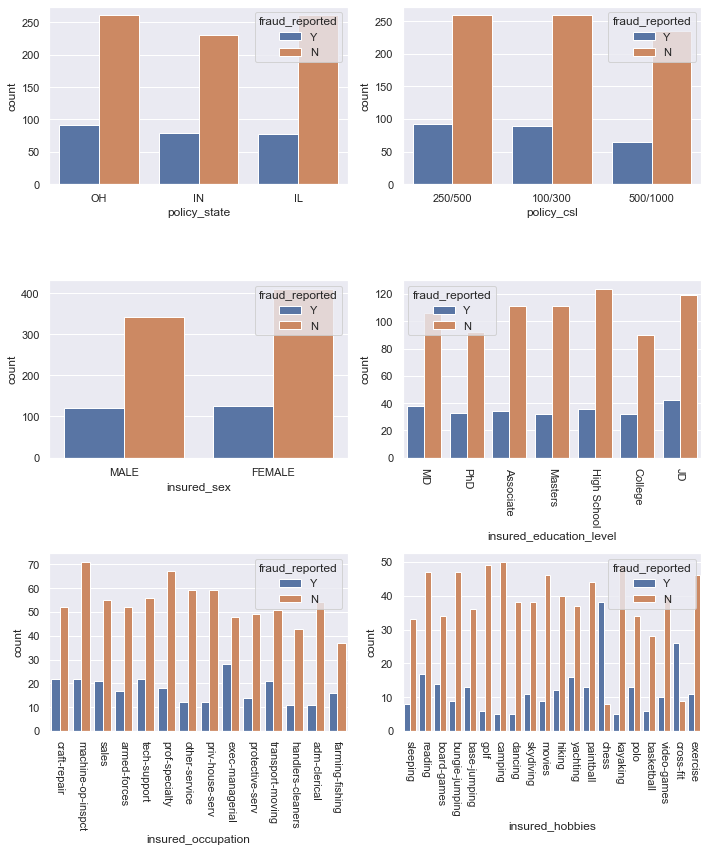

In [130]:
for i,col in enumerate(cat[0:6]):
    plt.subplot(3,2 ,i+1)
    sb.countplot(x = col, hue = 'fraud_reported', data = ds2)
    fig, ax = plt.gcf(), plt.gca()
    if col in ['insured_education_level','insured_hobbies','insured_occupation']:
        plt.xticks(rotation = -90)
    else:
        pass
    fig.set_size_inches(10, 12)
    plt.tight_layout()
plt.show()

From above bar charts, for insured_hobbies column, we see that customers who play chess and cross-fit as there hobbies, have higher fraud reported, particularly for chess, as fraud reported is significantly higher. So, in order to properly capture this information, we shall dummy encode this column.

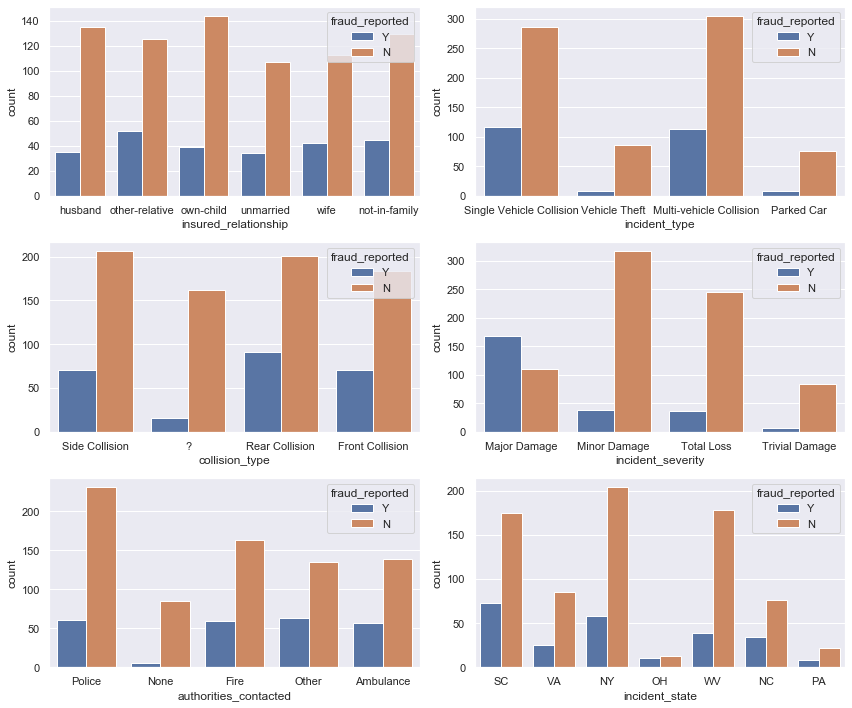

In [131]:
for i,col in enumerate(cat[6:12]):
    plt.subplot(3,2 ,i+1)
    sb.countplot(x = col, hue = 'fraud_reported', data = ds2)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(12, 10)
    plt.tight_layout()
plt.show()

From above plot, we see that in incident_severity, particularly for major damage cases, fraud is likely to occur. So, we shall dummy encode this column to capture its importance.

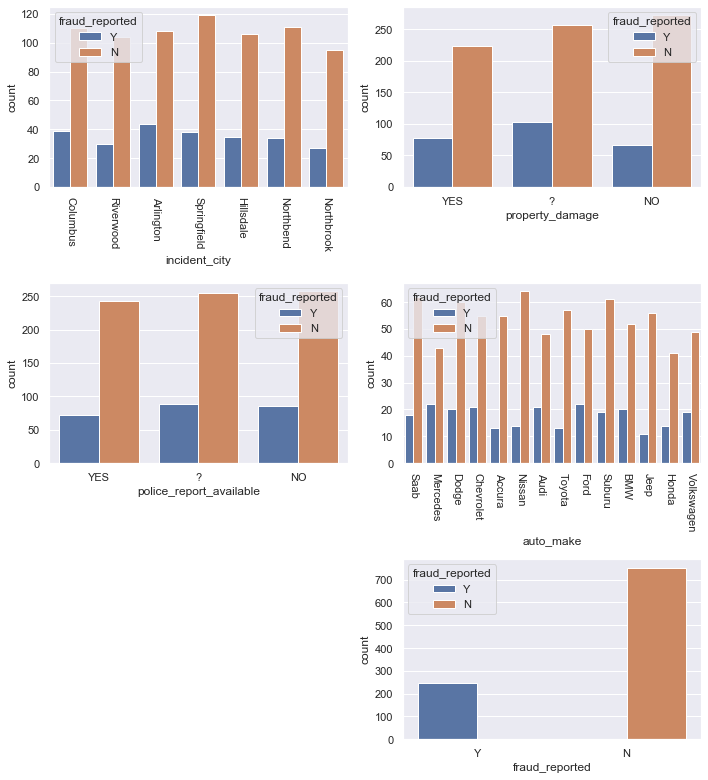

In [132]:
for i,col in enumerate(cat[12:18]):
    if col != 'auto_model':
        plt.subplot(3,2 ,i+1)
        sb.countplot(x = col, hue = 'fraud_reported', data = ds2)
        fig, ax = plt.gcf(), plt.gca()
        if col in ['incident_city','auto_make']:
            plt.xticks(rotation = -90)
        else:
            pass
        fig.set_size_inches(10, 11)
        plt.tight_layout()
plt.show()

 Fraud seems to occurs higher for expensive car companies like Ford, BMW, Audi, Chevrolet, Mercedes etc.
 
 Also, number of fraud cases are significantly lower, which implies imbalance in our dataset.

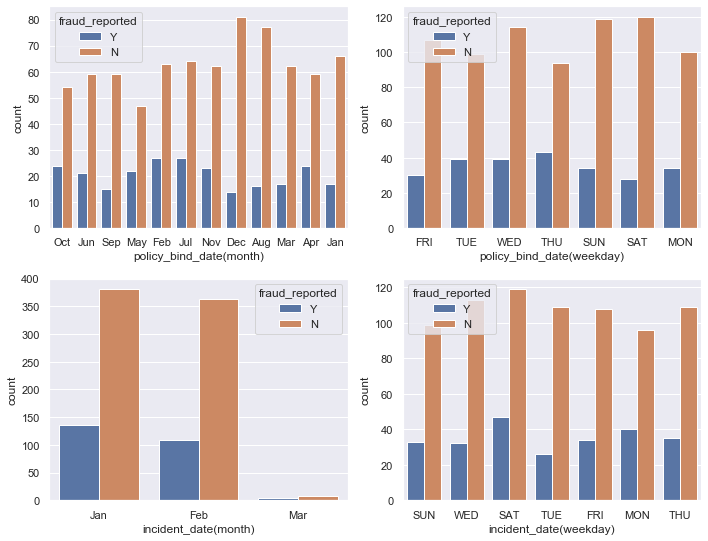

In [133]:
for i,col in enumerate(cat[18:]):
    plt.subplot(3,2 ,i+1)
    sb.countplot(x = col, hue = 'fraud_reported', data = ds2)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 11)
    plt.tight_layout()
plt.show()

We see that, number of fraud cases have some variations with respect to policy bind dates and incident dates.

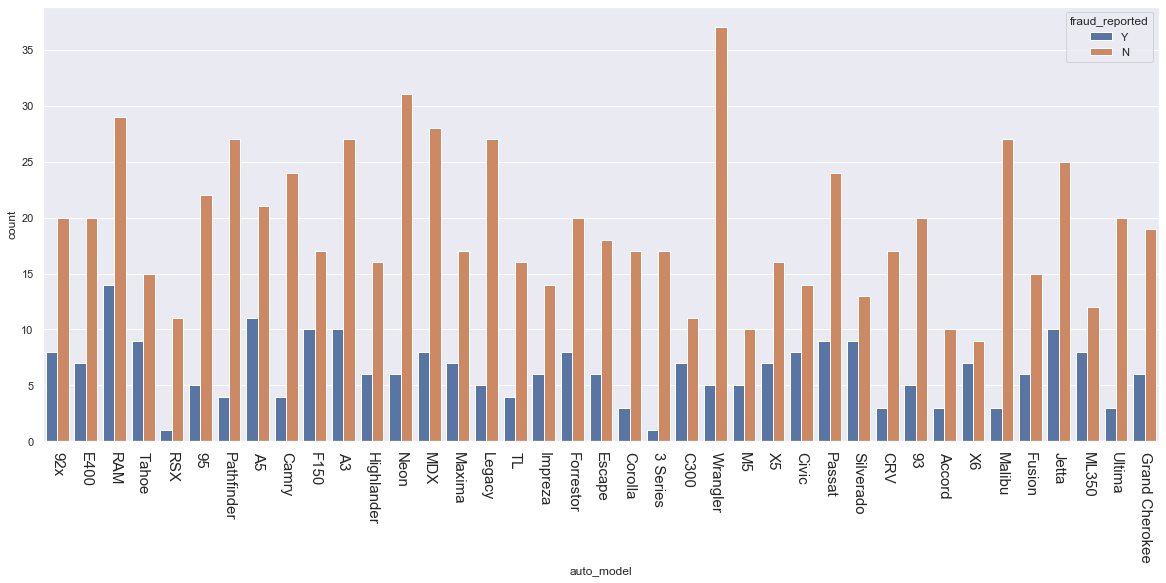

In [134]:
plt.figure(figsize = (20,8))
sb.countplot(x = 'auto_model', hue = 'fraud_reported', data = ds2)
plt.xticks(fontsize = 15,rotation = -90)
plt.show()

We see obvious variations in number of fraud cases with respect to each auto model.

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 <a list of 17 Text xticklabel objects>)

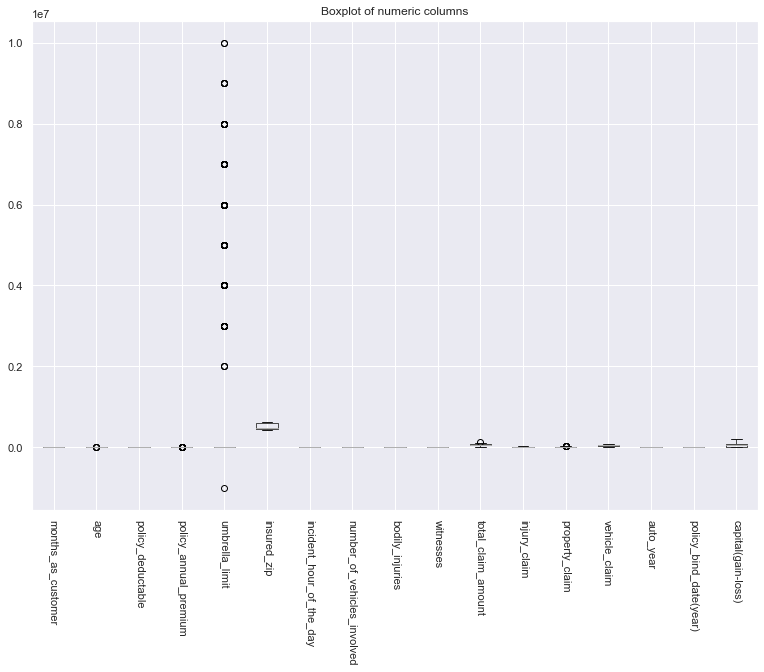

In [135]:
ds2.boxplot(column = numeric , figsize = (13,9))
plt.title('Boxplot of numeric columns')
plt.xticks(rotation = -90)

From above boxplots, we see that some features are in different scale, also there may be presence of outliers.

In [136]:
for col in cat:
    print('no. of unique values of column ' + col + ': ', len(ds2[col].unique()))

no. of unique values of column policy_state:  3
no. of unique values of column policy_csl:  3
no. of unique values of column insured_sex:  2
no. of unique values of column insured_education_level:  7
no. of unique values of column insured_occupation:  14
no. of unique values of column insured_hobbies:  20
no. of unique values of column insured_relationship:  6
no. of unique values of column incident_type:  4
no. of unique values of column collision_type:  4
no. of unique values of column incident_severity:  4
no. of unique values of column authorities_contacted:  5
no. of unique values of column incident_state:  7
no. of unique values of column incident_city:  7
no. of unique values of column property_damage:  3
no. of unique values of column police_report_available:  3
no. of unique values of column auto_make:  14
no. of unique values of column auto_model:  39
no. of unique values of column fraud_reported:  2
no. of unique values of column policy_bind_date(month):  12
no. of unique va

In [137]:
for col in numeric:
    print('no. of unique values of column ' + col + ': ', len(ds2[col].unique()))

no. of unique values of column months_as_customer:  391
no. of unique values of column age:  46
no. of unique values of column policy_deductable:  3
no. of unique values of column policy_annual_premium:  991
no. of unique values of column umbrella_limit:  11
no. of unique values of column insured_zip:  995
no. of unique values of column incident_hour_of_the_day:  24
no. of unique values of column number_of_vehicles_involved:  4
no. of unique values of column bodily_injuries:  3
no. of unique values of column witnesses:  4
no. of unique values of column total_claim_amount:  763
no. of unique values of column injury_claim:  638
no. of unique values of column property_claim:  626
no. of unique values of column vehicle_claim:  726
no. of unique values of column auto_year:  21
no. of unique values of column policy_bind_date(year):  26
no. of unique values of column capital(gain-loss):  522


In [138]:
# appending feature names from numeric list to cat list that have unqiue value less or equal to 11.
for col in numeric:
    if len(ds2[col].unique()) <= 11:
        cat.append(col)

In [139]:
# removing feature names from numeric list that have unqiue value less or equal to 11.
for col in list(numeric):
    if len(ds2[col].unique()) <= 11:
        numeric.remove(col)           

In [140]:
cat

['policy_state',
 'policy_csl',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'insured_relationship',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'property_damage',
 'police_report_available',
 'auto_make',
 'auto_model',
 'fraud_reported',
 'policy_bind_date(month)',
 'policy_bind_date(weekday)',
 'incident_date(month)',
 'incident_date(weekday)',
 'policy_deductable',
 'umbrella_limit',
 'number_of_vehicles_involved',
 'bodily_injuries',
 'witnesses']

In [141]:
numeric

['months_as_customer',
 'age',
 'policy_annual_premium',
 'insured_zip',
 'incident_hour_of_the_day',
 'total_claim_amount',
 'injury_claim',
 'property_claim',
 'vehicle_claim',
 'auto_year',
 'policy_bind_date(year)',
 'capital(gain-loss)']

In [142]:
# mapping target variable for modelling
ds2['fraud_reported'] = ds2['fraud_reported'].map({'Y':1, 'N':0 })

In [143]:
ds2

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,auto_make,auto_model,auto_year,fraud_reported,policy_bind_date(year),policy_bind_date(month),policy_bind_date(weekday),incident_date(month),incident_date(weekday),capital(gain-loss)
0,328,48,OH,250/500,1000,1406.91,0,466132,MALE,MD,...,Saab,92x,2004,1,2014,Oct,FRI,Jan,SUN,53300
1,228,42,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,...,Mercedes,E400,2007,1,2006,Jun,TUE,Jan,WED,0
2,134,29,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,...,Dodge,RAM,2007,0,2000,Sep,WED,Feb,SUN,35100
3,256,41,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,...,Chevrolet,Tahoe,2014,1,1990,May,FRI,Jan,SAT,111300
4,228,44,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,...,Accura,RSX,2009,0,2014,Jun,FRI,Feb,TUE,112000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,OH,500/1000,1000,1310.80,0,431289,FEMALE,Masters,...,Honda,Accord,2006,0,1991,Jul,TUE,Feb,SUN,0
996,285,41,IL,100/300,1000,1436.79,0,608177,FEMALE,PhD,...,Volkswagen,Passat,2015,0,2014,Jan,SUN,Jan,SAT,70900
997,130,34,OH,250/500,500,1383.49,3000000,442797,FEMALE,Masters,...,Suburu,Impreza,1996,0,2003,Feb,MON,Jan,FRI,35100
998,458,62,IL,500/1000,2000,1356.92,5000000,441714,MALE,Associate,...,Audi,A5,1998,0,2011,Nov,FRI,Feb,THU,0


In [144]:
cat.remove('fraud_reported') # removing target column from cat list.

In [86]:
# Here again, we are trying to tune the smoothing parameter using cross validation on training-set.
# for classification task.
x_train, x_test, y_train, y_test = train_test_split(ds2.drop(['fraud_reported'],1), 
                                                     ds2.fraud_reported ,
                                                     stratify = ds2.fraud_reported,
                                                     random_state = 42,
                                                     test_size = 0.3)

for col in  numeric:
    
    optb = OptimalBinning(name =  col, dtype="numerical",
                      solver="cp",
                      outlier_detector  =  'range',
                      class_weight = 'balanced')
    optb.fit(x_train[col].values, y_train)
   
    
    x_train[col] = optb.transform(x_train[col].values , metric='woe')
    x_test[col] = optb.transform(x_test[col].values , metric='woe')



score_list = []
smoothing_list = np.arange(0,5,.125)
model  = xgboost.XGBClassifier(silent = True) # using xgboost model for tuning smoothing parameter.
for num in smoothing_list:
    x_train_en = x_train.copy()
    
    for col in cat:
        

        encoder =  ce.TargetEncoder(cols = col, smoothing = num)
        x_train_en[col] = encoder.fit_transform(x_train_en[col], y_train)
    score = cross_val_score(model, x_train_en, y_train, cv = 10, scoring = 'f1_macro', n_jobs = -1 ).mean()
    score_list.append(score)
        
print('Optimum cross-val-score:',max(score_list),
      'corresponds to smoothing value of:',smoothing_list[score_list.index(max(score_list))])    

Optimum cross-val-score: 0.8173833731407921 corresponds to smoothing value of: 4.375


In [192]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(ds2.drop(['fraud_reported'],1), 
                                                     ds2.fraud_reported ,
                                                     stratify = ds2.fraud_reported,
                                                     random_state = 42,
                                                     test_size = 0.3)

In [193]:
# features to dummy encode.
ohe = ['incident_severity','insured_hobbies']

In [194]:
# target encoding features that are in target_encoding_list using tuned smoothing value as 4.375.
for col in cat:
    if col not in ohe:
        encoder =  ce.TargetEncoder(cols = col, smoothing = 4.375)
        x_train[col] = encoder.fit_transform(x_train[col], y_train)
        x_test[col] = encoder.transform(x_test[col])

In [195]:
# dummy encoding variables in ohe list.
x_train = pd.get_dummies(data = x_train, prefix = ohe, columns = ohe)
x_test = pd.get_dummies(data = x_test, prefix = ohe, columns = ohe)

In [196]:
x_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,insured_hobbies_hiking,insured_hobbies_kayaking,insured_hobbies_movies,insured_hobbies_paintball,insured_hobbies_polo,insured_hobbies_reading,insured_hobbies_skydiving,insured_hobbies_sleeping,insured_hobbies_video-games,insured_hobbies_yachting
235,428,54,0.244344,0.276860,0.268182,1506.21,0.230769,453407,0.245399,0.242718,...,0,1,0,0,0,0,0,0,0,0
497,0,32,0.258475,0.228155,0.224066,1377.04,0.230769,441363,0.245399,0.250000,...,0,0,0,0,0,0,0,0,0,0
169,47,37,0.244344,0.234127,0.268182,1241.97,0.230769,430104,0.245399,0.205357,...,0,0,1,0,0,0,0,0,0,0
511,283,48,0.258475,0.228155,0.224066,1474.66,0.230769,446755,0.248663,0.258065,...,0,0,0,1,0,0,0,0,0,0
208,343,48,0.244344,0.234127,0.251046,1451.54,0.225671,473412,0.245399,0.258065,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,276,45,0.238683,0.228155,0.251046,948.10,0.230769,430621,0.248663,0.205357,...,0,0,0,0,0,1,0,0,0,0
789,169,34,0.244344,0.276860,0.251046,1469.75,0.230769,458132,0.248663,0.258065,...,0,0,0,0,0,1,0,0,0,0
240,249,43,0.238683,0.234127,0.224066,1518.46,0.230769,606238,0.248663,0.277778,...,0,0,0,0,0,0,0,0,0,0
263,244,40,0.244344,0.228155,0.268182,1304.67,0.211115,605408,0.245399,0.242718,...,0,0,0,0,0,0,0,0,0,0


In [197]:
# supervised binning numerical columns using 'OptimalBinning' class.

for col in  numeric:
    
    optb = OptimalBinning(name =  col, dtype="numerical",
                      solver="cp",
                      outlier_detector  =  'range',
                      class_weight = 'balanced')
    optb.fit(x_train[col].values, y_train)
    print('binning status for column ' + col+ ' is',optb.status,'\n')
    
    x_train[col] = optb.transform(x_train[col].values , metric='woe')
    x_test[col] = optb.transform(x_test[col].values , metric='woe')

binning status for column months_as_customer is OPTIMAL 

binning status for column age is OPTIMAL 

binning status for column policy_annual_premium is OPTIMAL 

binning status for column insured_zip is OPTIMAL 

binning status for column incident_hour_of_the_day is OPTIMAL 

binning status for column total_claim_amount is OPTIMAL 

binning status for column injury_claim is OPTIMAL 

binning status for column property_claim is OPTIMAL 

binning status for column vehicle_claim is OPTIMAL 

binning status for column auto_year is OPTIMAL 

binning status for column policy_bind_date(year) is OPTIMAL 

binning status for column capital(gain-loss) is OPTIMAL 



Here, we have supervised binned numeric columns and transformed it on the basis of weigth of evidence (woe), as it will be robust to skewed datas as well as outliers.

In [198]:
x_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,insured_hobbies_hiking,insured_hobbies_kayaking,insured_hobbies_movies,insured_hobbies_paintball,insured_hobbies_polo,insured_hobbies_reading,insured_hobbies_skydiving,insured_hobbies_sleeping,insured_hobbies_video-games,insured_hobbies_yachting
235,-0.418308,-0.089479,0.244344,0.276860,0.268182,-0.142906,0.230769,0.030215,0.245399,0.242718,...,0,1,0,0,0,0,0,0,0,0
497,-0.203167,-0.119938,0.258475,0.228155,0.224066,-0.142906,0.230769,0.323202,0.245399,0.250000,...,0,0,0,0,0,0,0,0,0,0
169,-0.203167,0.516657,0.244344,0.234127,0.268182,0.261807,0.230769,1.352443,0.245399,0.205357,...,0,0,1,0,0,0,0,0,0,0
511,0.150688,0.091598,0.258475,0.228155,0.224066,-0.142906,0.230769,0.030215,0.248663,0.258065,...,0,0,0,1,0,0,0,0,0,0
208,-0.418308,0.091598,0.244344,0.234127,0.251046,-0.142906,0.225671,-0.134393,0.245399,0.258065,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0.150688,0.091598,0.238683,0.228155,0.251046,-0.179376,0.230769,1.352443,0.248663,0.205357,...,0,0,0,0,0,1,0,0,0,0
789,-0.002251,-0.119938,0.244344,0.276860,0.251046,-0.142906,0.230769,-0.124823,0.248663,0.258065,...,0,0,0,0,0,1,0,0,0,0
240,0.150688,0.091598,0.238683,0.234127,0.224066,-0.195505,0.230769,-0.145442,0.248663,0.277778,...,0,0,0,0,0,0,0,0,0,0
263,0.150688,0.091598,0.244344,0.228155,0.268182,-0.142906,0.211115,-0.145442,0.245399,0.242718,...,0,0,0,0,0,0,0,0,0,0


In [204]:
# feature selection  using selectkbest
selector = SelectKBest(mutual_info_classif, k = 'all')
selector.fit(x_train, y_train)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x0000024D7C3EF318>)

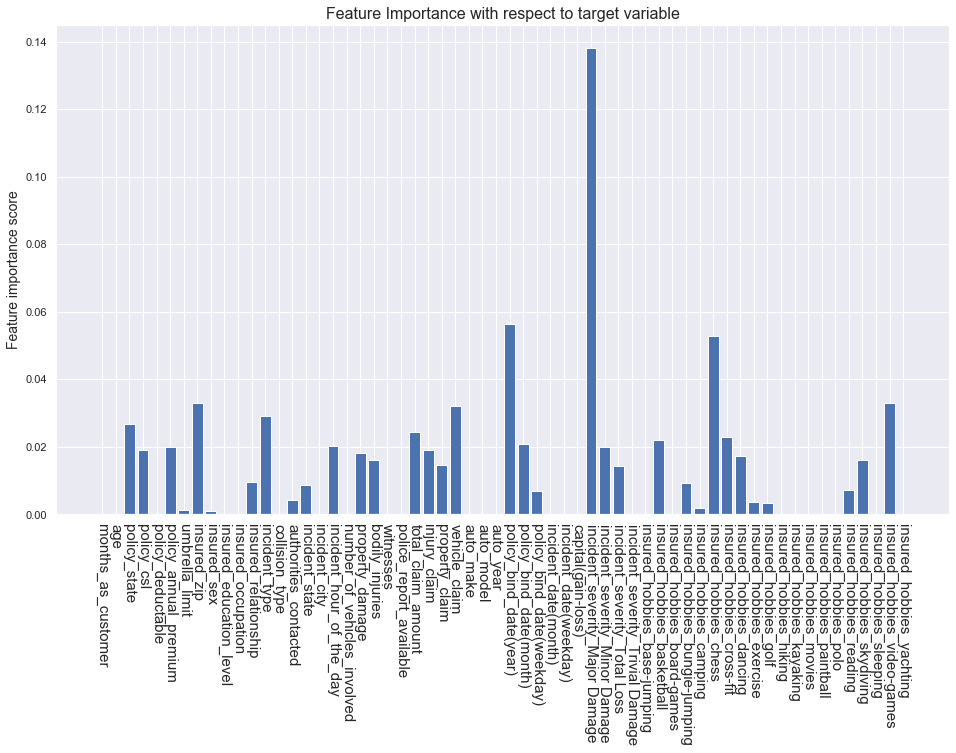

In [205]:
# plotting the feature scores
plt.figure(figsize = (16,9))
plt.bar(x_train.columns, selector.scores_)
plt.xticks(rotation = -90, fontsize = 15)
plt.title('Feature Importance with respect to target variable', fontsize = 16)
plt.ylabel('Feature importance score', fontsize = 14)
plt.show()

From above feature importance plots, we see that major damage as incident_severity has highest importance followed by hobby as chess and policy_bind_date(year), for predicting fraud cases.

We also see that, most features have almost no relevance in predicting the target variable.

In [206]:
selector = pd.DataFrame(dict(Feature = list(x_train.columns), Scores = selector.scores_))
selector.sort_values(by = 'Scores', ascending = False ).head(30)

,Feature,Scores
36,incident_severity_Major Damage,0.137964
30,policy_bind_date(year),0.056245
45,insured_hobbies_chess,0.052852
7,insured_zip,0.032868
58,insured_hobbies_video-games,0.032848
26,vehicle_claim,0.032065
12,incident_type,0.029151
2,policy_state,0.026855
23,total_claim_amount,0.024548
46,insured_hobbies_cross-fit,0.023072


In [215]:
# keeping features with scores above threshold score.
threshold = 0.015
selected_features = selector[selector.Scores > threshold]
selected_features.sort_values(by = 'Scores', ascending = False )

,Feature,Scores
36,incident_severity_Major Damage,0.137964
30,policy_bind_date(year),0.056245
45,insured_hobbies_chess,0.052852
7,insured_zip,0.032868
58,insured_hobbies_video-games,0.032848
26,vehicle_claim,0.032065
12,incident_type,0.029151
2,policy_state,0.026855
23,total_claim_amount,0.024548
46,insured_hobbies_cross-fit,0.023072


In [216]:
print('no. of selected features:', len(selected_features))

no. of selected features: 21


In [217]:
# selecting highest scoring features for train and test set.
x_train_red = x_train[list(selected_features['Feature'])]
x_test_red = x_test[list(selected_features['Feature'])]

In [218]:
x_train_red

,policy_state,policy_csl,policy_annual_premium,insured_zip,incident_type,incident_hour_of_the_day,property_damage,bodily_injuries,total_claim_amount,injury_claim,...,policy_bind_date(year),policy_bind_date(month),incident_severity_Major Damage,incident_severity_Minor Damage,insured_hobbies_basketball,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_dancing,insured_hobbies_skydiving,insured_hobbies_video-games
235,0.244344,0.276860,-0.142906,0.030215,0.272727,-0.129232,0.176230,0.228700,-0.083682,-0.298015,...,0.051159,0.290323,0,1,0,0,0,0,0,0
497,0.258475,0.228155,-0.142906,0.323202,0.272727,0.138854,0.289157,0.228700,0.692196,-0.188200,...,0.051159,0.290323,0,1,0,0,0,0,0,0
169,0.244344,0.234127,0.261807,1.352443,0.089552,-0.129232,0.176230,0.228700,0.692196,1.151841,...,0.051159,0.206349,0,1,0,0,0,0,0,0
511,0.258475,0.228155,-0.142906,0.030215,0.089552,0.872007,0.289157,0.269231,0.692196,1.151841,...,-0.490464,0.224138,0,0,0,0,0,0,0,0
208,0.244344,0.234127,-0.142906,-0.134393,0.272727,-0.129232,0.176230,0.269231,-0.253480,-0.188200,...,0.051159,0.241379,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0.238683,0.228155,-0.179376,1.352443,0.272727,-0.129232,0.289157,0.242798,-0.253480,-0.298015,...,-0.079722,0.206349,0,1,0,0,0,0,0,0
789,0.244344,0.276860,-0.142906,-0.124823,0.292419,-0.063405,0.289157,0.242798,0.692196,-0.188200,...,-0.079722,0.317460,0,1,0,0,0,0,0,0
240,0.238683,0.234127,-0.195505,-0.145442,0.292419,-0.129232,0.289157,0.242798,-1.252064,0.020439,...,0.051159,0.218182,1,0,0,0,1,0,0,0
263,0.244344,0.228155,-0.142906,-0.145442,0.272727,0.138854,0.289157,0.228700,-0.253480,0.020439,...,-0.079722,0.171875,0,1,0,0,0,0,0,0


In [219]:
s = StratifiedKFold(n_splits = 10)

### Base Model Evaluation

model: RandomForestClassifier()
CV score:0.7935504041403176
score_std: 0.04283240417413236
----------
model: LogisticRegression()
CV score:0.7931815193881637
score_std: 0.054818470899039684
----------
model: SVC()
CV score:0.8074287748810335
score_std: 0.05138567043081623
----------
model: AdaBoostClassifier()
CV score:0.7544112441575871
score_std: 0.05424008789019428
----------
model: GradientBoostingClassifier()
CV score:0.7871893015236102
score_std: 0.03803547357529855
----------
model: KNeighborsClassifier()
CV score:0.7768843146216124
score_std: 0.04855176007770681
----------
model: XGBClassifier(silent=True)
CV score:0.8007539765663069
score_std: 0.03723787434319128
----------
model: DecisionTreeClassifier()
CV score:0.6846824992195918
score_std: 0.06390174082294194
----------
model: GaussianNB()
CV score:0.7723112613433014
score_std: 0.10409606430695531
----------


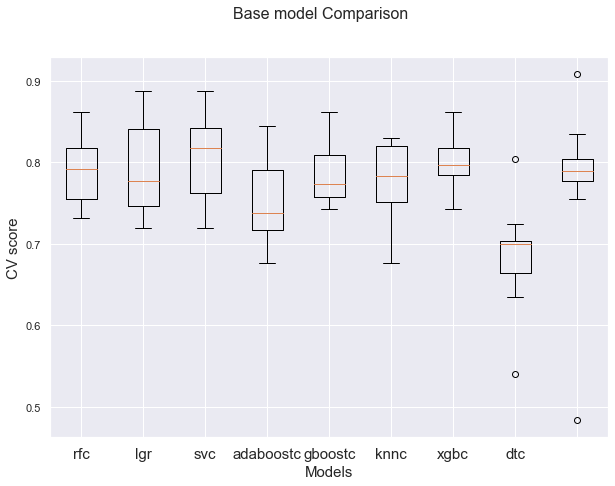

In [220]:
rfc = RandomForestClassifier()
svc = SVC()
lgr = LogisticRegression()
adaboostc =  AdaBoostClassifier()
gboostc = GradientBoostingClassifier()
knnc = KNeighborsClassifier()
xgbc = xgboost.XGBClassifier(silent = True)
dtc = DecisionTreeClassifier()
gnb  = GaussianNB()

models = [rfc, lgr, svc, adaboostc, gboostc, knnc, xgbc, dtc, gnb]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train_red, y_train, cv = s
                            , scoring = 'f1_macro', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 16)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rfc', 'lgr','svc', 'adaboostc', 'gboostc', 'knnc', 'xgbc','dtc',],
                  fontsize = 15)
plt.xlabel('Models', fontsize = 15)
plt.ylabel('CV score', fontsize = 15)
fig.set_size_inches(10,7)
plt.show() 

Bases on the above cross-val-scores, except for dtc, we shall select all models for tuning and testing.

### Hyper-parameter tuning

In [221]:
# initializing all model's parameter
param_gboostc =  dict(
   learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.5, 0.6 ],
   max_depth = [ 2, 3, 4, 5, 6, 8, 10, 12, 15],
   n_estimators = [30 ,50,75,100, 150, 200],
   min_samples_split = [1,2,3],
   min_samples_leaf = [1,2], random_state = [41,42,43])

param_xgbc = dict( learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     max_depth = [ 2, 3, 4, 5, 6, 8, 10, 12, 15],
     min_child_weight = [ 1, 3, 5, 7 ],
     gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ], alpha = [0.05,0.1,0.5,0.75,1,1.75,2],
                 reg_lambda = [0.05,0.1,0.5,0.75,1,1.75,2])

param_lgr = dict(penalty = ['l1','l2'],  C = np.logspace(4,-4,60), 
                 solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 max_iter = [100,150,200,250,300])

param_adaboostc = dict(n_estimators = [50, 100, 150, 200],
                    learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                     algorithm = ['SAMME', 'SAMME.R'],
                      random_state = [41,42,43])

param_svc = dict(kernel = ['rbf','linear','poly', 'sigmoid'], gamma = np.arange(0.25,3,0.25), degree = [2,3],
             C =np.logspace(4,-4,40))

param_rfc = dict(n_estimators = [10,15,20,25,30], criterion = ['gini', 'entropy'],
                max_depth = [3,4,5,6,7,8,None],min_samples_split = [2,3,4],
                min_samples_leaf = [1,2,3], random_state = [41,42,43])

param_knnc = dict(n_neighbors = np.arange(1,30,1), algorithm = ['auto','ball_tree','kd_tree','brute'],
                leaf_size = [25,30,35], p = [1,2], weights = ['uniform','distance'])

In [222]:
model_param_list = [( gboostc,param_gboostc), ( xgbc,param_xgbc), (lgr,param_lgr),
                   (adaboostc, param_adaboostc), (svc, param_svc) ,(rfc,param_rfc), (knnc, param_knnc)]

In [223]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_search = RandomizedSearchCV(model, param, cv = s, n_jobs = -1, scoring = 'f1_macro',
                                  random_state = 42)
    r_search.fit( x_train_red, y_train.values.ravel())
    best_cvscore = r_search.best_score_
    best_param = r_search.best_params_
    best_estimator = r_search.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
    
print('best_estimators:',best_estimator_list)

model: GradientBoostingClassifier()
best_cvscore: 0.7656253981298567
best_param: {'random_state': 42, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 6, 'learning_rate': 0.6}


model: XGBClassifier(silent=True)
best_cvscore: 0.7935903978081851
best_param: {'reg_lambda': 1, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7, 'alpha': 0.75}


model: LogisticRegression()
best_cvscore: 0.8090776414367584
best_param: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 300, 'C': 14.208308325339223}


model: AdaBoostClassifier()
best_cvscore: 0.774739256096095
best_param: {'random_state': 41, 'n_estimators': 200, 'learning_rate': 0.2, 'algorithm': 'SAMME.R'}


model: SVC()
best_cvscore: 0.8029617149319735
best_param: {'kernel': 'linear', 'gamma': 1.0, 'degree': 3, 'C': 0.11937766417144358}


model: RandomForestClassifier()
best_cvscore: 0.777841289484207
best_param: {'random_state': 43, 'n_estimators': 15, 'min

In [224]:
best_estimator_list.append(gnb) # appending GaussianNB algorithm for testing. 

### Testing

In [225]:
print('*******TRAIN RESULTS*******')
print('\n')

for model in best_estimator_list:
    model.fit(x_train_red, y_train.values.ravel())
    y_pred = model.predict(x_train_red)
    score = accuracy_score(y_train, y_pred)
    print('model',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score (macro):',round(f1_score(y_train,y_pred, average = 'macro')*100,2),'%','\n')
    print('auc_roc_score:', round(roc_auc_score(y_train,y_pred)*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_train, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TRAIN RESULTS*******


model GradientBoostingClassifier(learning_rate=0.6, max_depth=6, n_estimators=200,
                           random_state=42) 

accuracy: 100.0 % 

f1_score (macro): 100.0 % 

auc_roc_score: 100.0 % 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       527
           1       1.00      1.00      1.00       173

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

------------------------------------------------------------------------------


model XGBClassifier(alpha=0.75, colsample_bytree=0.7, gamma=0.4, max_depth=10,
              min_child_weight=3, silent=True) 

accuracy: 96.14 % 

f1_score (macro): 94.72 % 

auc_roc_score: 93.94 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       527


In [226]:
print('*******TEST RESULTS********')
print('\n')

for model in best_estimator_list:
    model.fit(x_train_red, y_train.values.ravel())
    y_pred = model.predict(x_test_red)
    score = accuracy_score(y_test, y_pred)
    
    print('Model:',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score (macro):',round(f1_score(y_test,y_pred, average = 'macro')*100,2),'%','\n')
    print('auc_roc_score:', round(roc_auc_score(y_test,y_pred)*100,2),'%','\n')
    print('confusion_matrix:','\n',confusion_matrix(y_test,y_pred),'\n')
    print('Classification report:','\n', classification_report(y_test, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TEST RESULTS********


Model: GradientBoostingClassifier(learning_rate=0.6, max_depth=6, n_estimators=200,
                           random_state=42) 

accuracy: 82.0 % 

f1_score (macro): 75.33 % 

auc_roc_score: 74.87 % 

confusion_matrix: 
 [[201  25]
 [ 29  45]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       226
           1       0.64      0.61      0.62        74

    accuracy                           0.82       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.82      0.82      0.82       300

------------------------------------------------------------------------------


Model: XGBClassifier(alpha=0.75, colsample_bytree=0.7, gamma=0.4, max_depth=10,
              min_child_weight=3, silent=True) 

accuracy: 83.33 % 

f1_score (macro): 76.71 % 

auc_roc_score: 75.76 % 

confusion_matrix: 
 [[205  21]
 [ 29  45]] 

Classification report: 
               prec

From above train and test results, we see that SVM model performed the best compared to other models in  the test set, based on f1 score (macro) and and roc auc score,which therefore, gives us the confidence to test on unseen data.

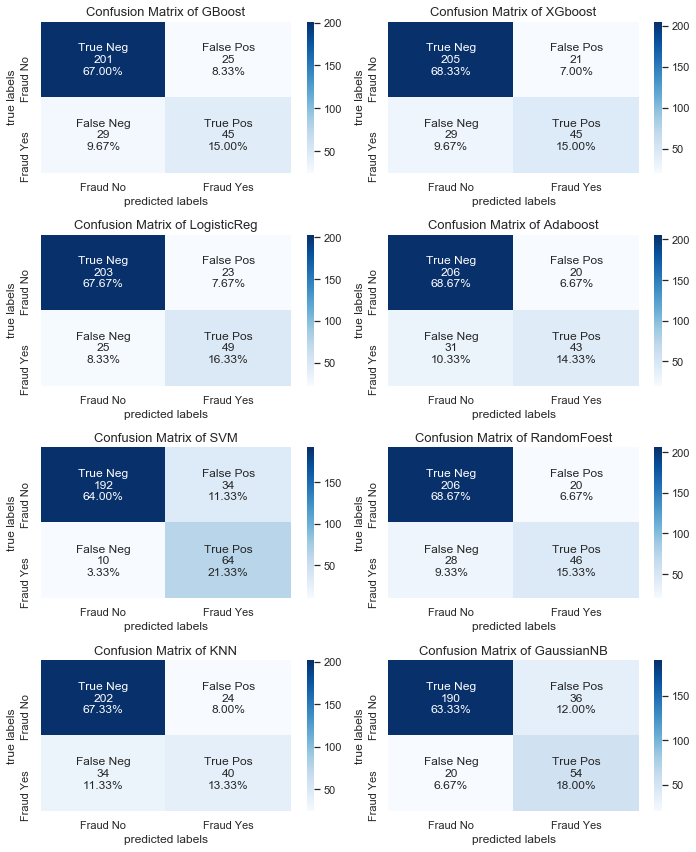

In [227]:
# visualizing confusion matrix  with the help of heatmaps.
model_index = [0,1,2,3,4,5,6,7]
model = ['GBoost','XGboost','LogisticReg','Adaboost','SVM','RandomFoest','KNN','GaussianNB']

for index ,model, model_name in zip(model_index,best_estimator_list,model):
    plt.subplot(4,2, index + 1 )
    model.fit(x_train_red, y_train)
    y_pred = model.predict(x_test_red)
    c_matric = confusion_matrix(y_test, y_pred)
    groups = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                c_matric.flatten()]
    group_percent = ['{0:.2%}'.format(value) for value in
                     c_matric.flatten()/np.sum(c_matric)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(groups,group_counts,group_percent)]
    labels = np.asarray(labels).reshape(2,2)
    sb.heatmap(c_matric, annot=labels, fmt='', cmap='Blues')
    plt.title('Confusion Matrix of ' + model_name, fontsize = 13)
    plt.ylabel('true labels')
    plt.xlabel('predicted labels')
    fig, ax = plt.gcf(), plt.gca()
    ax.set_xticklabels(['Fraud No','Fraud Yes'])
    ax.set_yticklabels(['Fraud No','Fraud Yes'])
    fig.set_size_inches(10, 12)
    plt.tight_layout()
plt.show()

From above heatmaps, we see that SVM model has the lowest 'Type-II' errors and highest true positives, which is very crucial to correctly classify the minor class(i.e. in our case, Fraud Yes).

Hence, on the basis of anticipation and detection of  fraud cases, we can select SVM as our final model for this project.

In [228]:
# selecting the best model for classification.
selected_model = SVC(C=0.11937766417144358, gamma=1.0, kernel='linear')

selected_model.fit(x_train_red, y_train)

y_pred = selected_model.predict(x_test_red)

In [230]:
test_df = pd.DataFrame({'Actual Case':y_test.values,'Predicted Case':y_pred})

In [233]:
test_df.to_csv('auto_insurance_fraud_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


In [235]:
# Saving the final model as  SVM for classification problem.
joblib.dump(selected_model, 'auto_insurance_fraud_pred.obj')
print('Model successfully saved.')

Model successfully saved.
